In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
input_size = 784
hidden_size0 = 32
hidden_size1 = 16     
out_size = 1 #binary for whether it is digit or not
        
bin_digit = 6
epochs = 10            
batch_size = 64
learning_rate = 0.001

In [3]:
train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [5]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, out_size)
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.fc0.weight)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        
    def forward(self, x): #x = input img
        x = x.view(x.size(0), -1)  #flatten img, because (batch_size, 1, 28, 28) and nn.Linear expects (batch_size, features)
        out = self.relu(self.fc0(x))
        out = self.relu(self.fc1(out))
        out = self.fc2(out)

        return out

In [6]:
#create net
net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

#Loss: is it a specific number or not (e.g., 3)?
criterion = nn.BCEWithLogitsLoss() #uses sigmoid

#Optimiser for gradient descent:
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

![Alt Text](<https://miro.medium.com/v2/resize:fit:1003/1*1kCwAuqqte7r3LeiiP1FDQ.jpeg>)


In [7]:
print(CUDA)

True


In [8]:
#train:

for epoch in range(epochs):
    correct_train = 0
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        #(batch,1,28,28)
        images = images.view(-1, 28*28)
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()

        labels = (labels == bin_digit).float().view(-1, 1)  #if bin_digit: label = 1, else 0

        outputs = net(images)  #[batch_size, 1]

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = (torch.sigmoid(outputs) >= 0.5).float() #activated output (logits) to binary

        correct_train += (predicted == labels).sum().item()

    accuracy = 100 * correct_train / len(train_dataset)
    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss / len(train_loader):.3f}, Training Accuracy: {accuracy:.3f}%')

print("DONE TRAINING!")

torch.save(net.state_dict(), 'binary_ffn.pth')


Epoch [1/10], Training Loss: 0.054, Training Accuracy: 98.177%
Epoch [2/10], Training Loss: 0.019, Training Accuracy: 99.360%
Epoch [3/10], Training Loss: 0.012, Training Accuracy: 99.610%
Epoch [4/10], Training Loss: 0.009, Training Accuracy: 99.692%
Epoch [5/10], Training Loss: 0.007, Training Accuracy: 99.752%
Epoch [6/10], Training Loss: 0.006, Training Accuracy: 99.823%
Epoch [7/10], Training Loss: 0.005, Training Accuracy: 99.810%
Epoch [8/10], Training Loss: 0.004, Training Accuracy: 99.868%
Epoch [9/10], Training Loss: 0.003, Training Accuracy: 99.877%
Epoch [10/10], Training Loss: 0.003, Training Accuracy: 99.905%
DONE TRAINING!


In [9]:
#net.load_state_dict(torch.load('binary_ffn.pth'))

In [10]:
with torch.no_grad():
    correct = 0
    for images, labels in test_loader:
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
        images = images.view(-1, 28*28)
        labels = (labels == bin_digit).float().view(-1, 1)
        outputs = net(images)
        predicted = (torch.sigmoid(outputs) >= 0.5).float()
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / len(test_dataset)))

Accuracy of the network on the 10000 test images: 99.57 %


In [49]:
#failed ~43 here

In [11]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.ndimage import gaussian_filter
import random as ra

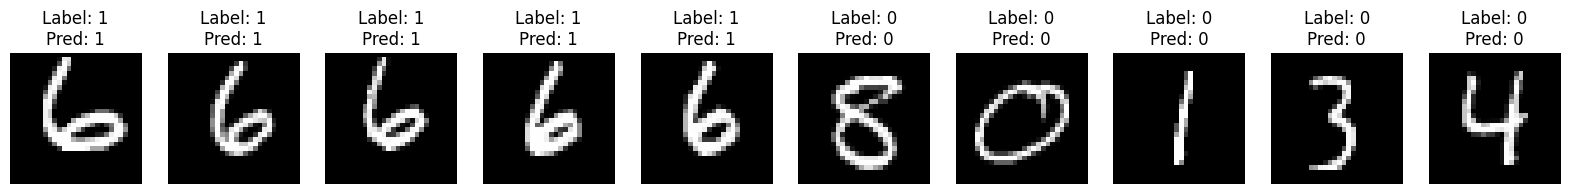

In [12]:
#examples:

net.eval()


data_iter = iter(test_loader)
batch_list = list(data_iter)
random_batch = ra.choice(batch_list)
images, labels = random_batch

pos_idx = (labels == bin_digit).nonzero(as_tuple=True)[0]
neg_idx = (labels != bin_digit).nonzero(as_tuple=True)[0]

n = 10  #how many imgs to display
half_n = n // 2
selected_idx = torch.cat([pos_idx[:half_n], neg_idx[:half_n]])

selected_images = images[selected_idx].cuda()
selected_labels = labels[selected_idx]

inputs = selected_images.view(selected_images.size(0), -1)
outputs = net(inputs)
preds = (torch.sigmoid(outputs) >= 0.5).float().squeeze().cpu() #activate logits out to binary 

plt.figure(figsize=(n * 2, 4))
for i in range(selected_images.size(0)):
    plt.subplot(1, n, i+1)
    plt.imshow(selected_images[i].cpu().squeeze(), cmap='gray')
    plt.title(f'Label: {int(selected_labels[i].item() == bin_digit)}\nPred: {int(preds[i])}')
    plt.axis('off')
plt.show()

In [13]:
#activation maximization, LRP:
from captum.attr import LRP

/home/kns357/Desktop/ann_ma_kaito/venv0/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Text(0.5, 1.0, 'average pixels per digit')

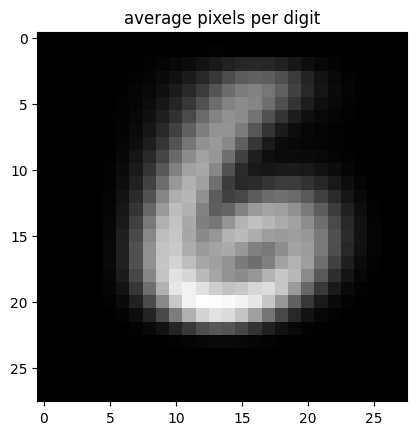

In [14]:
accumulator = np.zeros((1, 28, 28), dtype=np.float64)

count = 0
for img, label in train_dataset:
    if label == bin_digit:
        img = img.numpy()
        arr = np.array(img, dtype=np.float64)
        accumulator += arr
        count += 1

average_img = (accumulator / count).squeeze()
plt.imshow(average_img, cmap="gray")
plt.title("average pixels per digit")

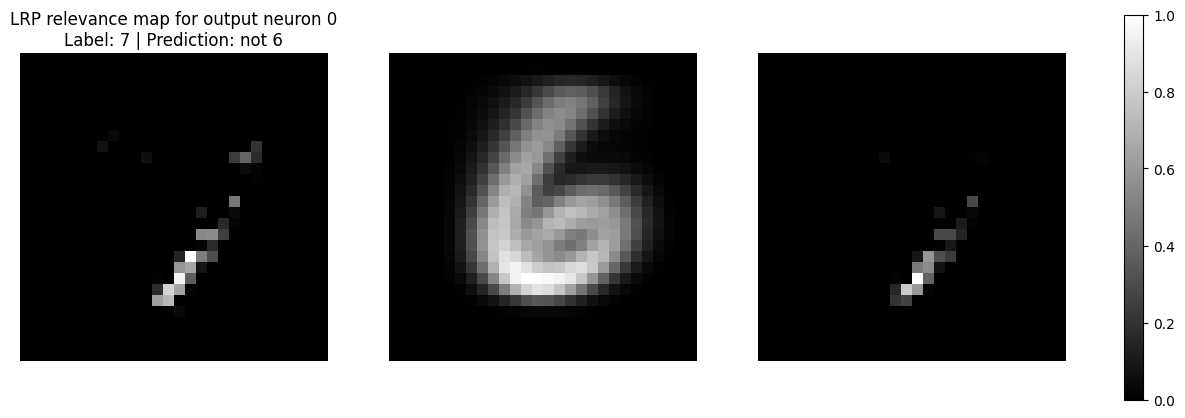

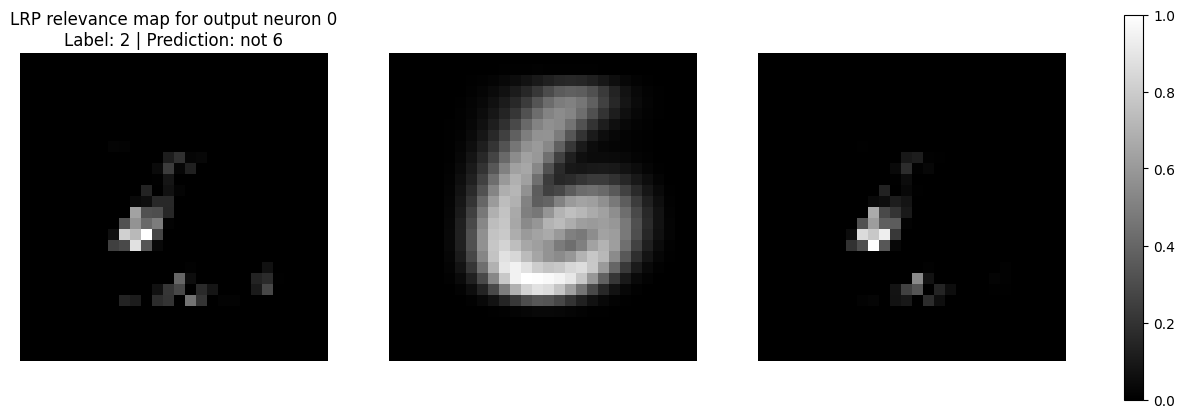

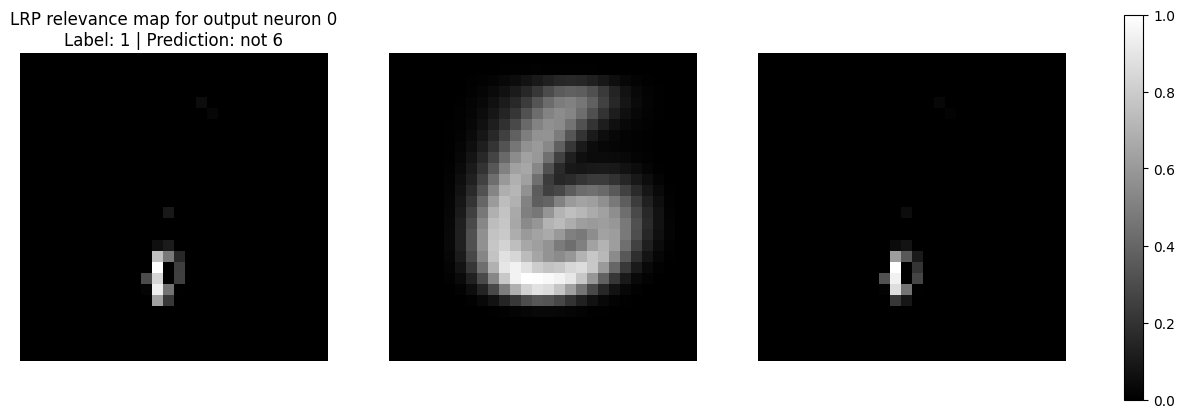

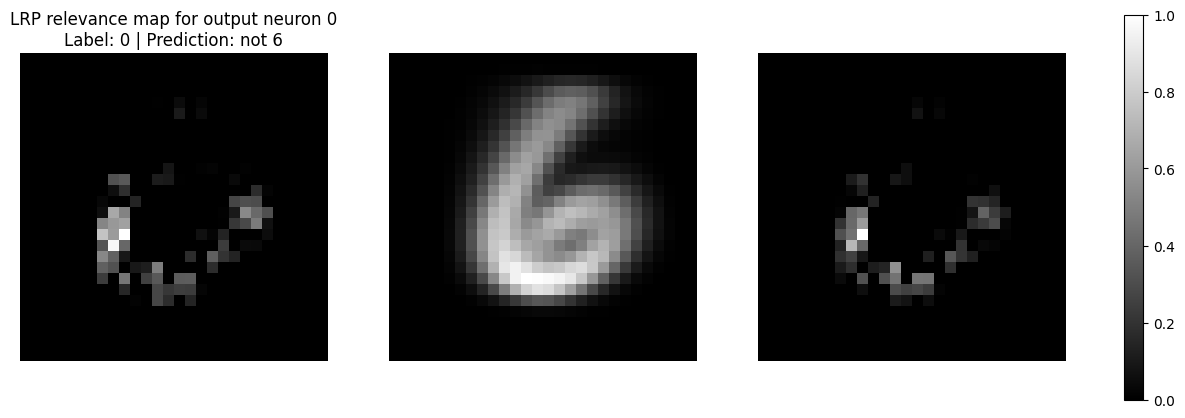

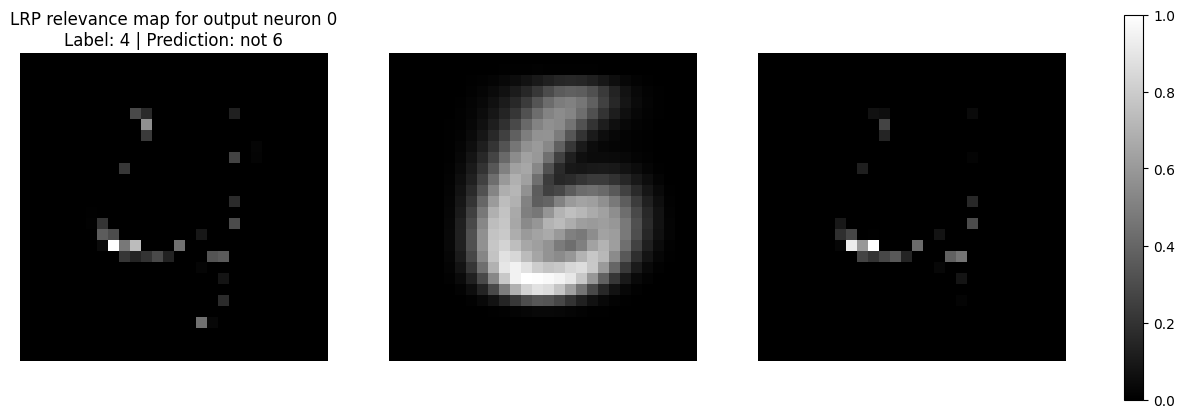

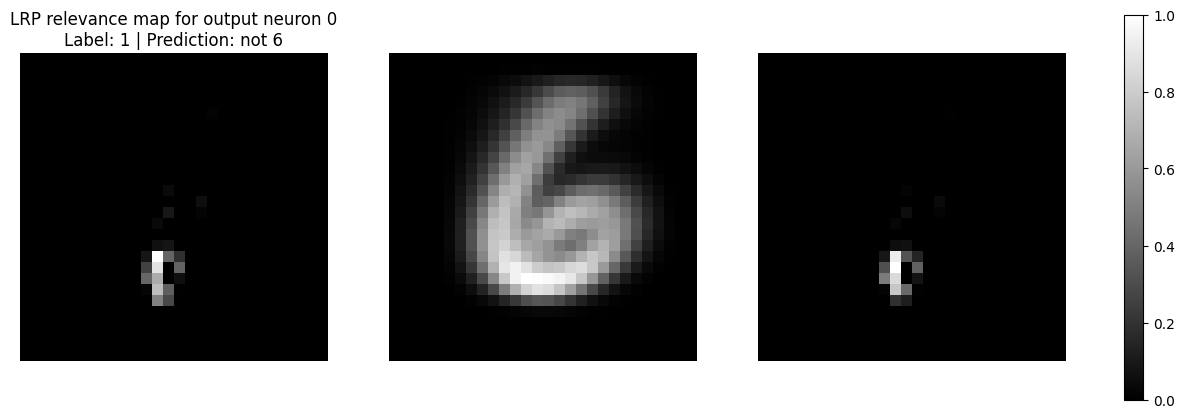

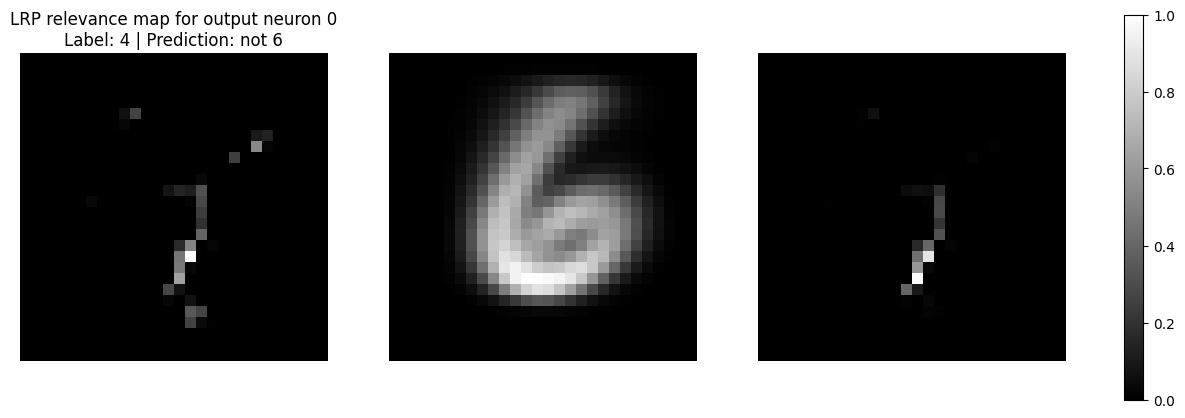

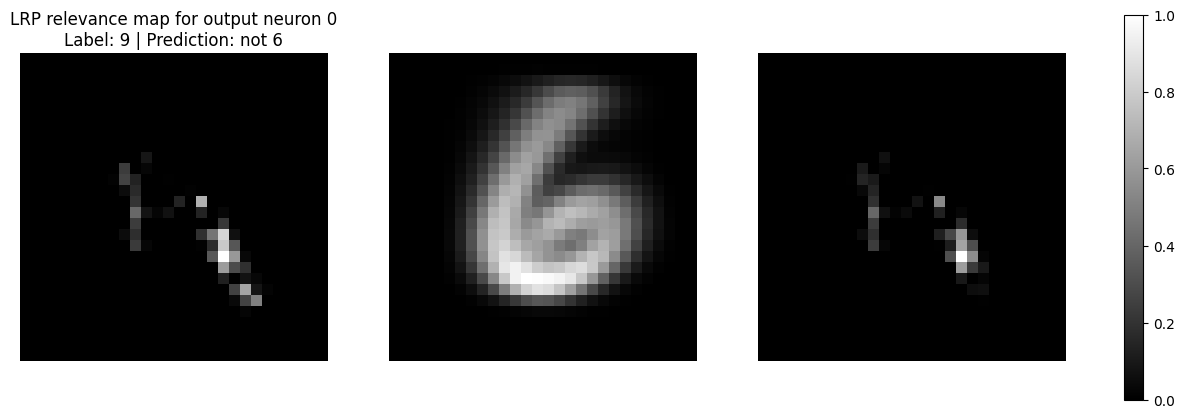

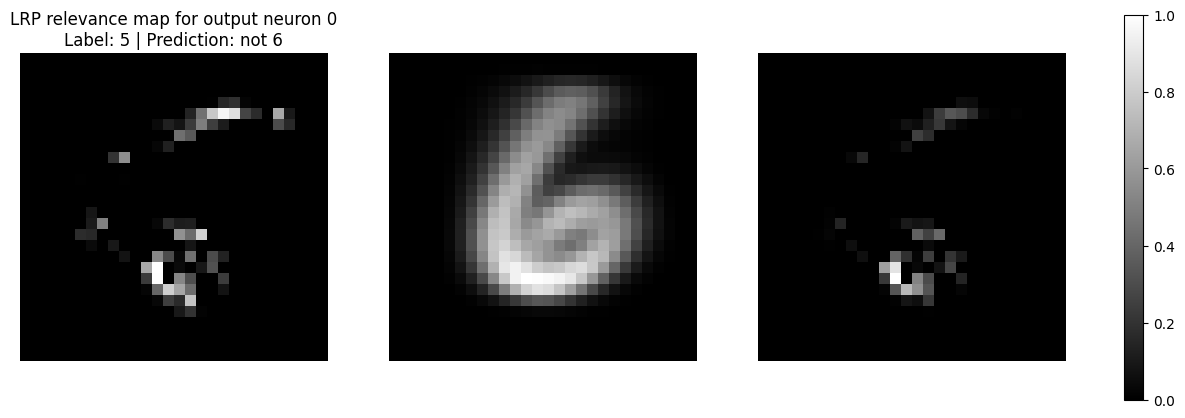

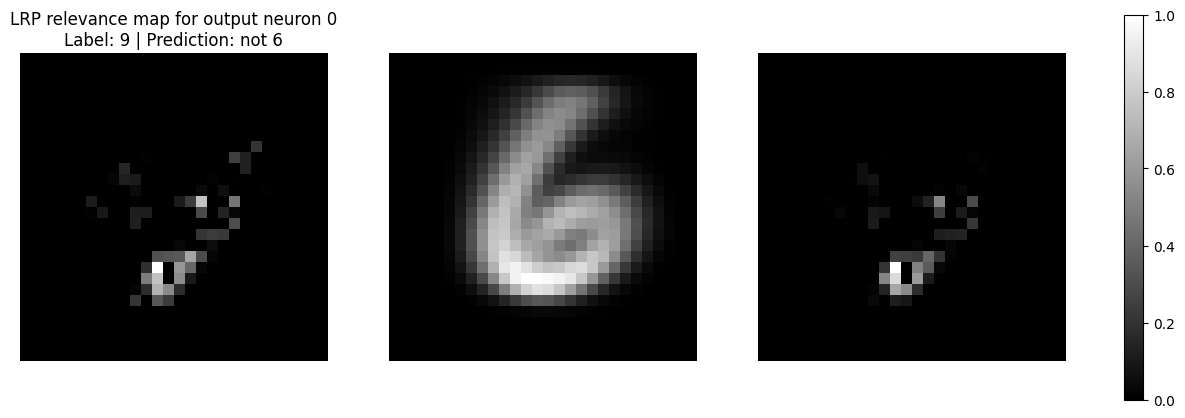

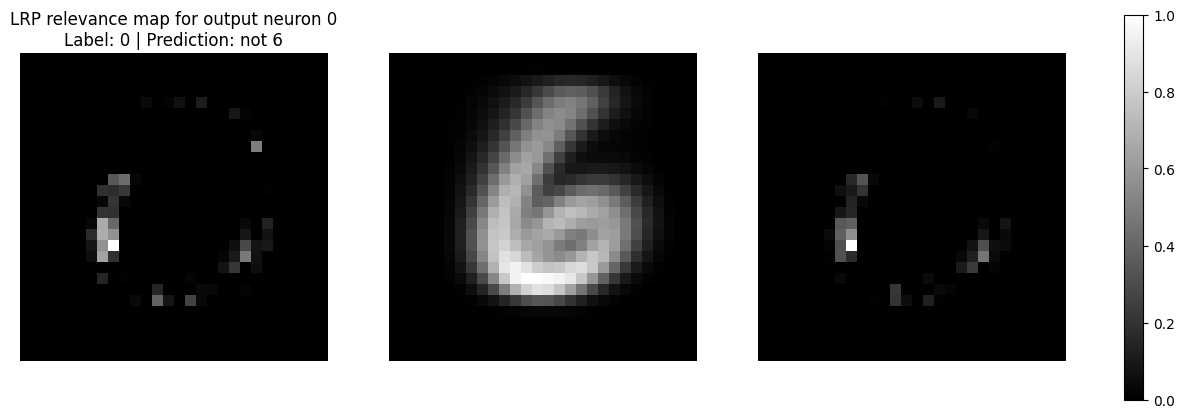

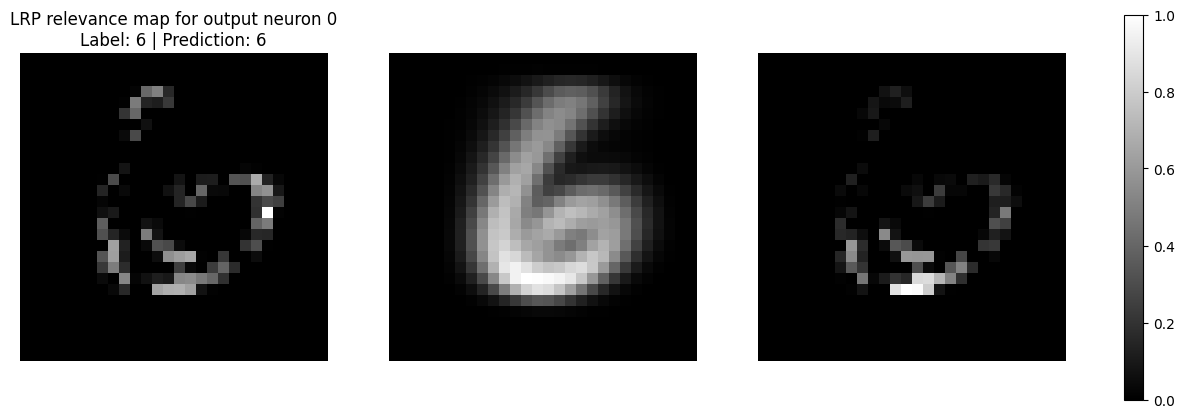

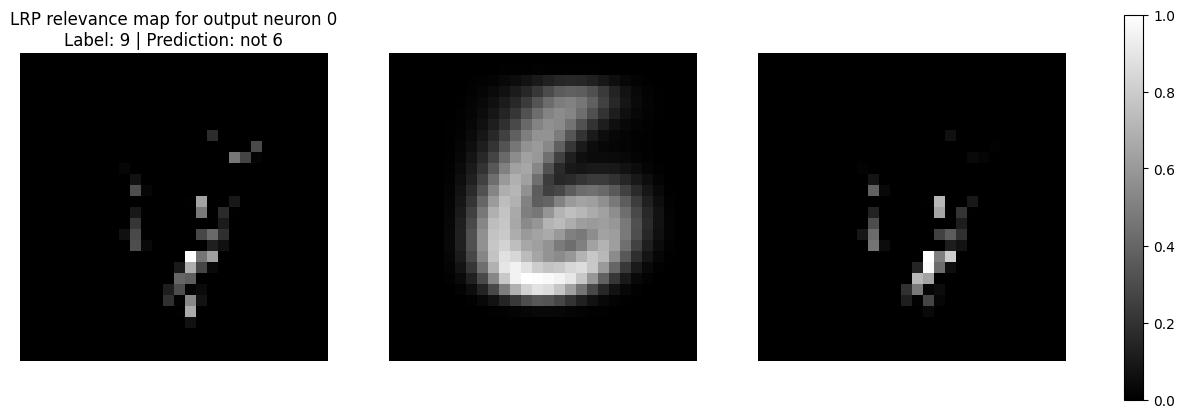

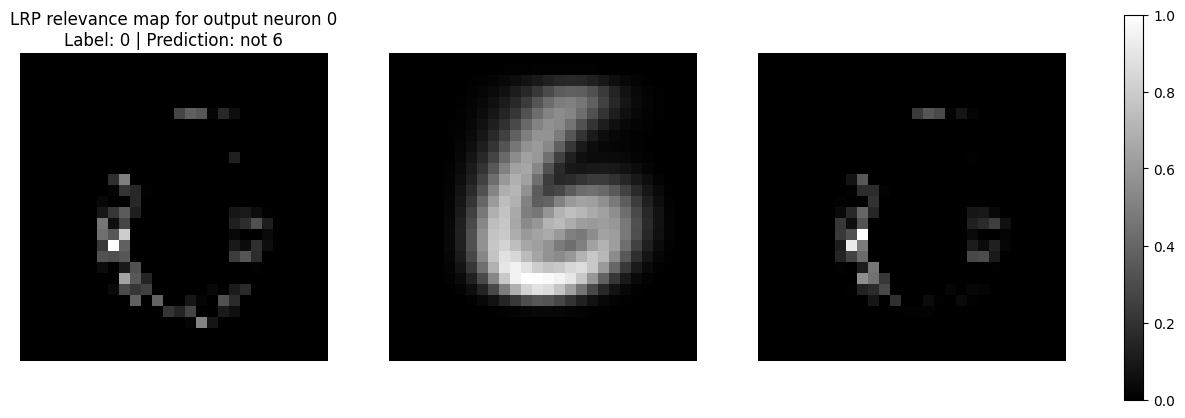

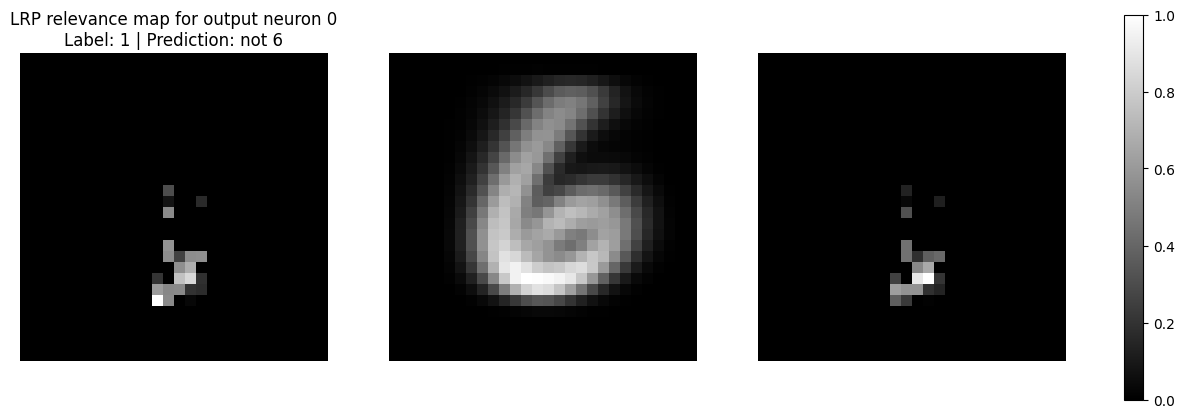

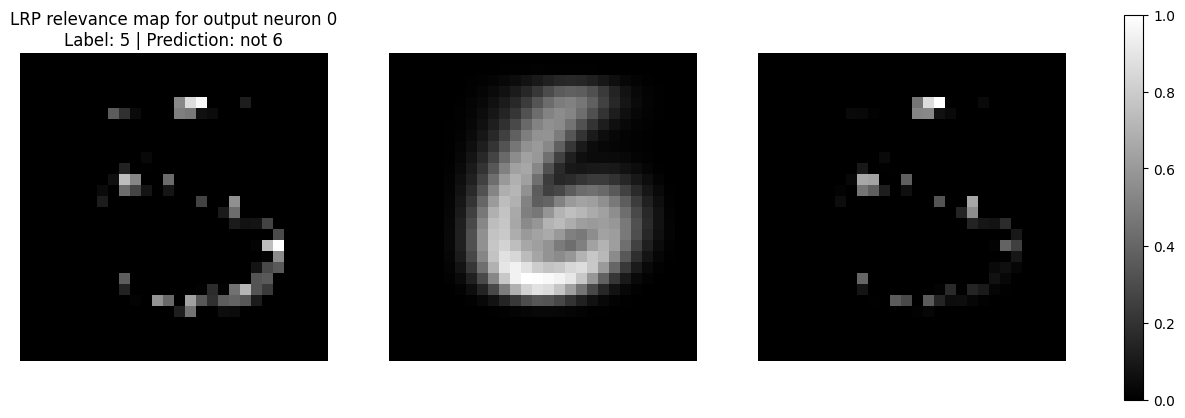

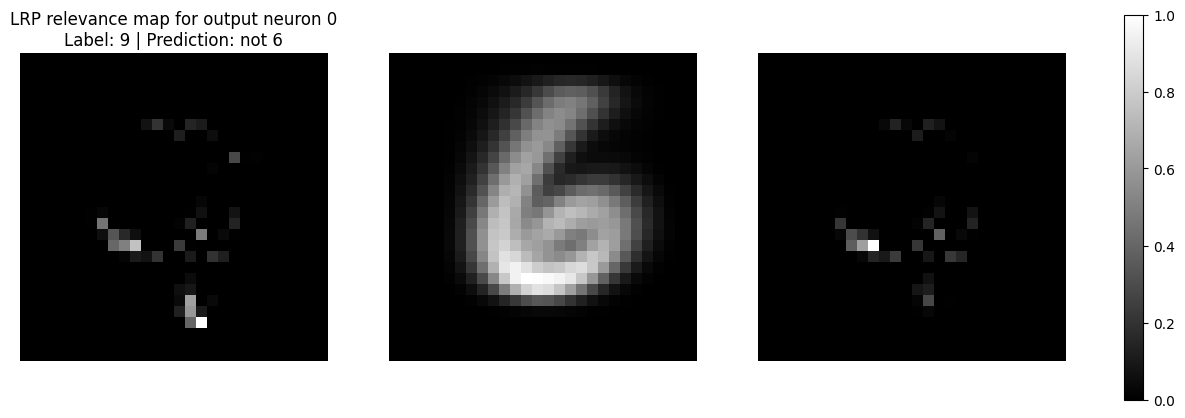

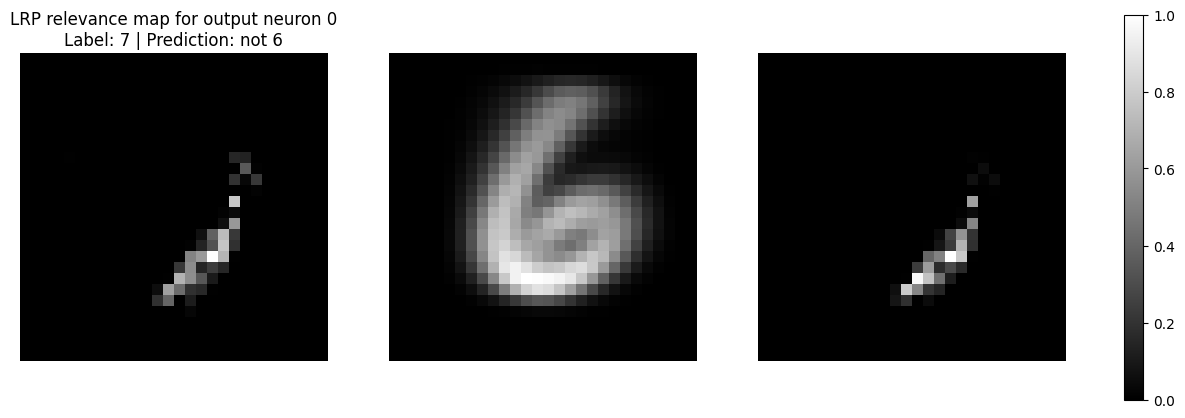

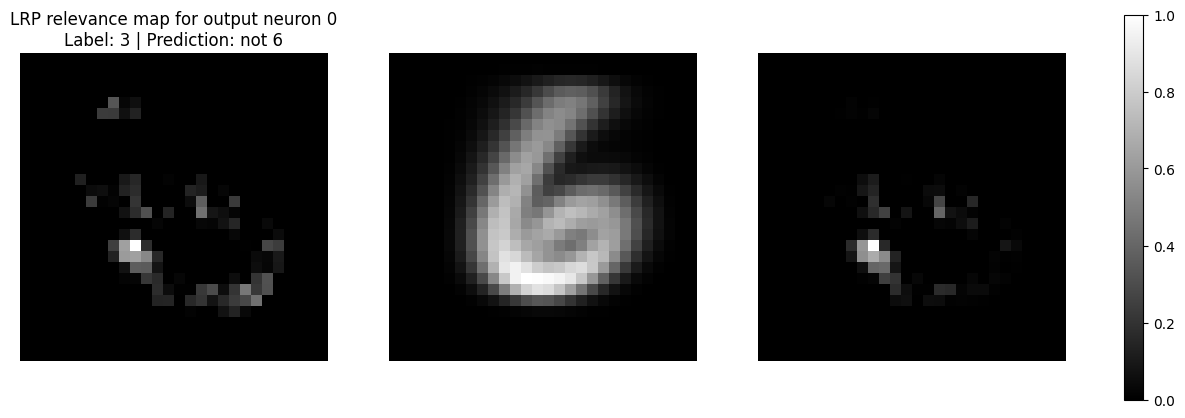

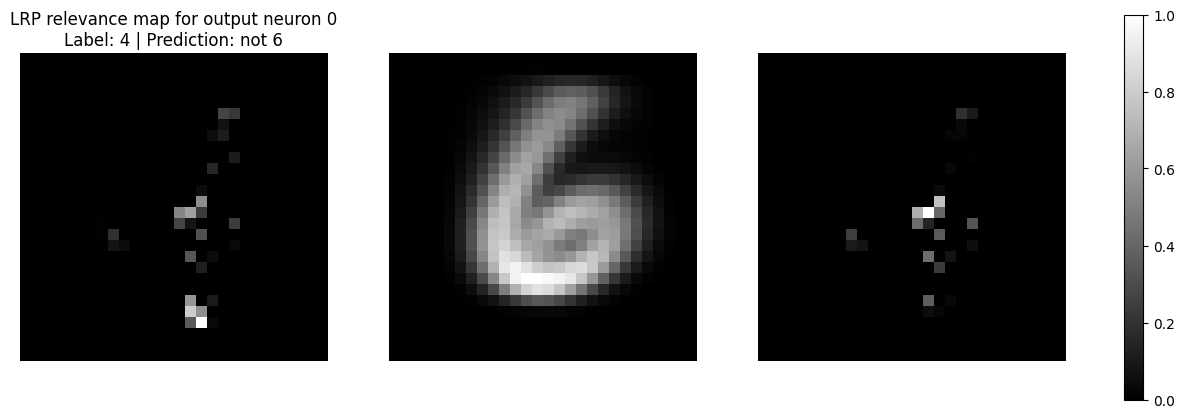

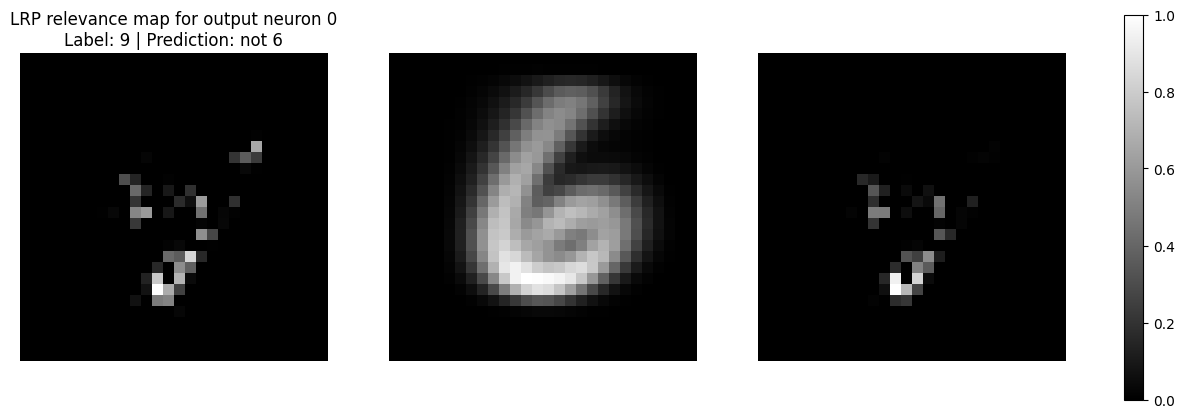

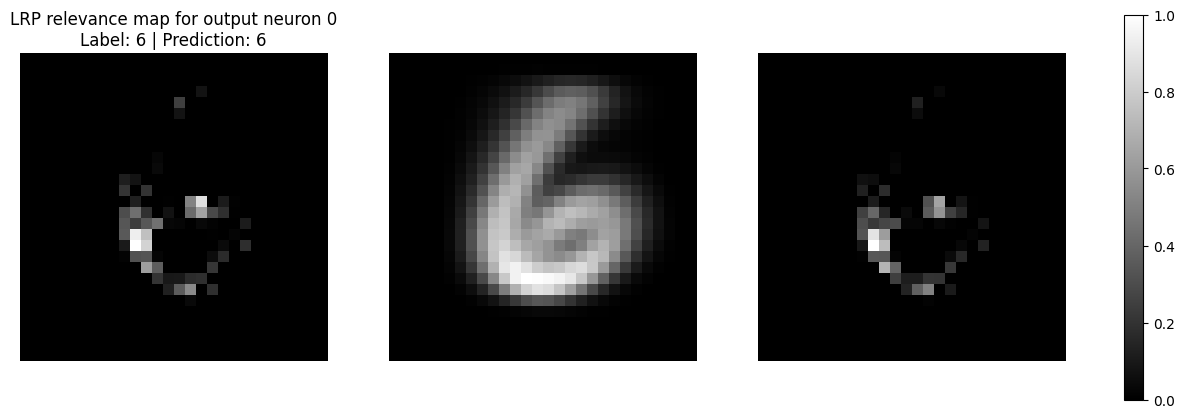

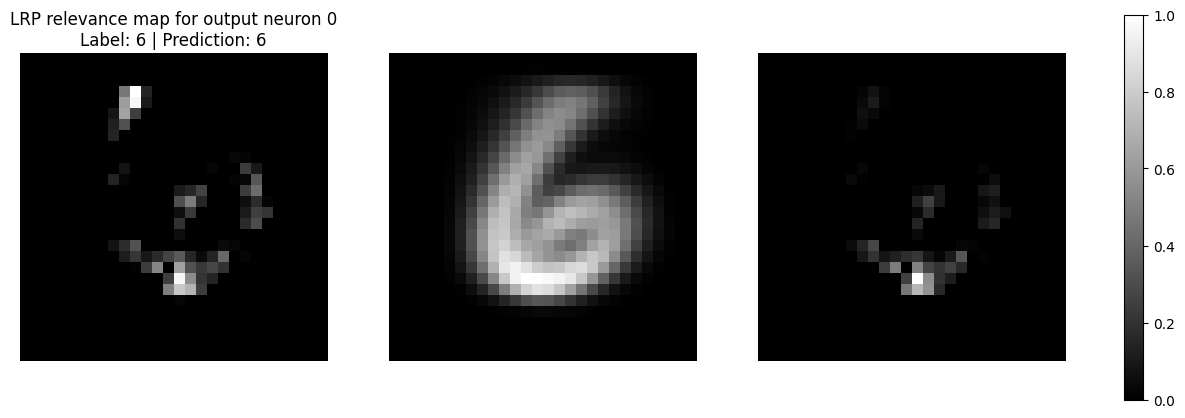

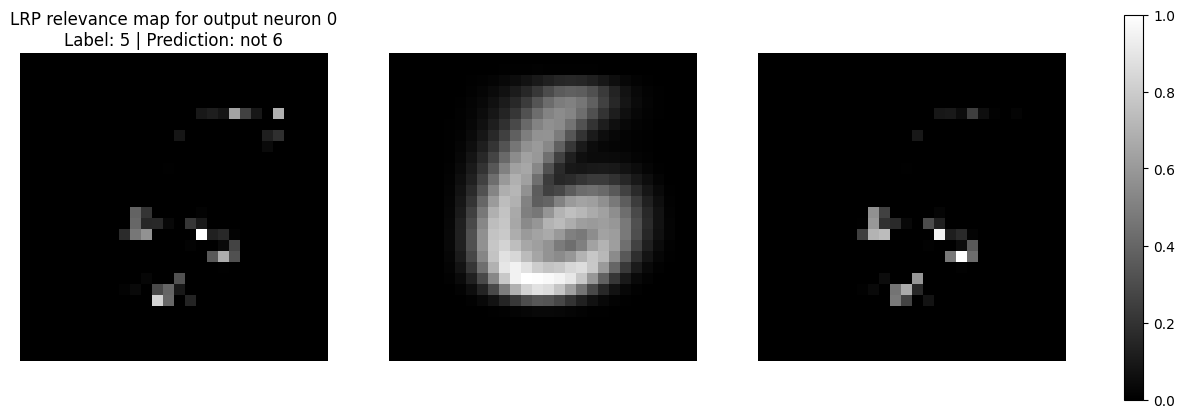

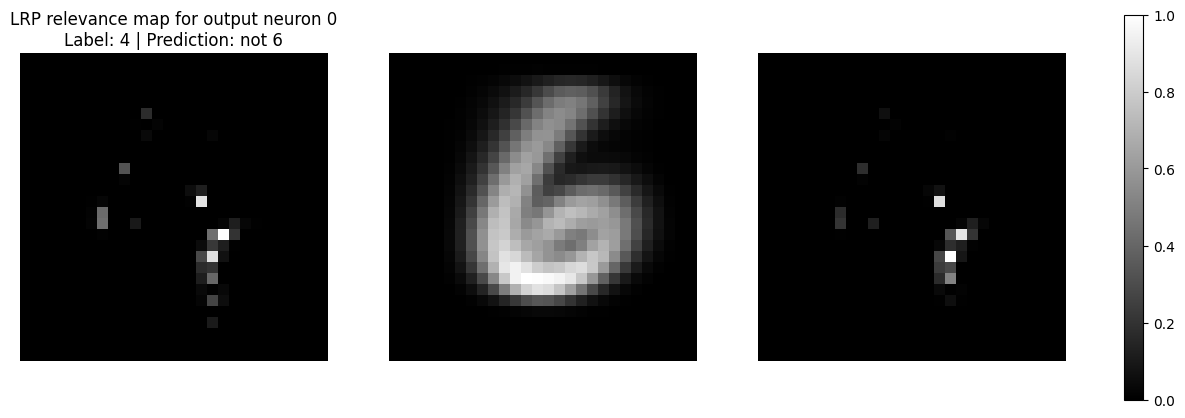

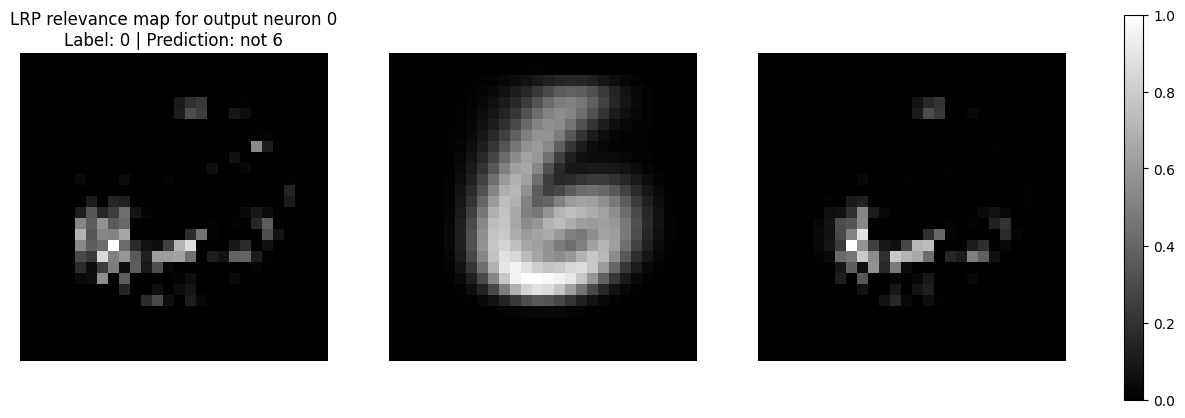

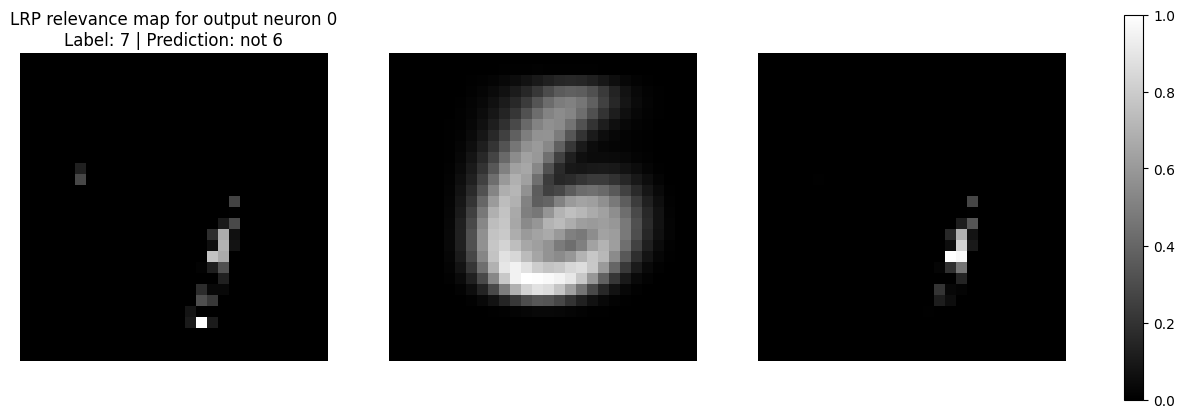

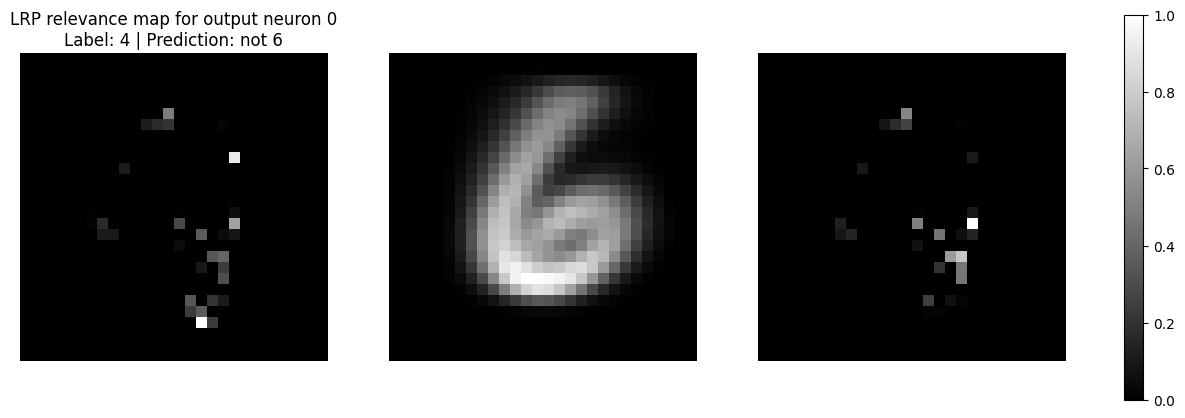

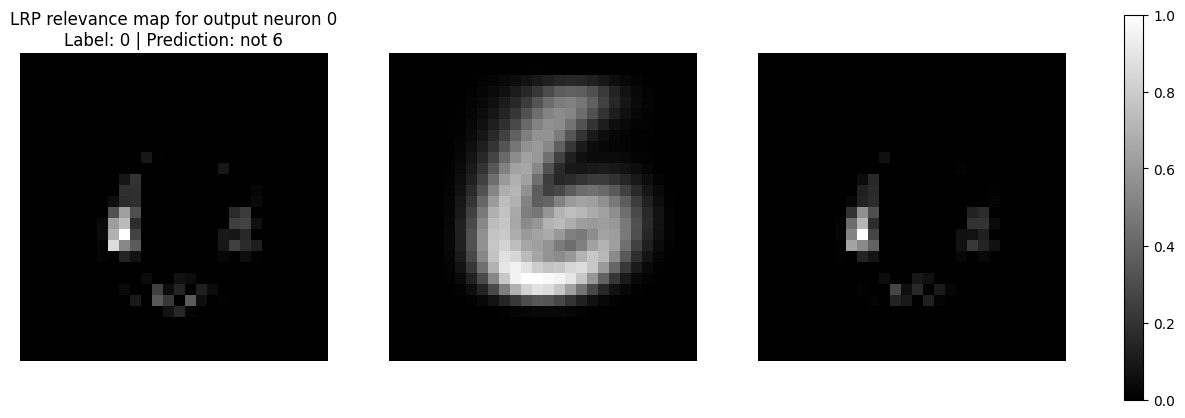

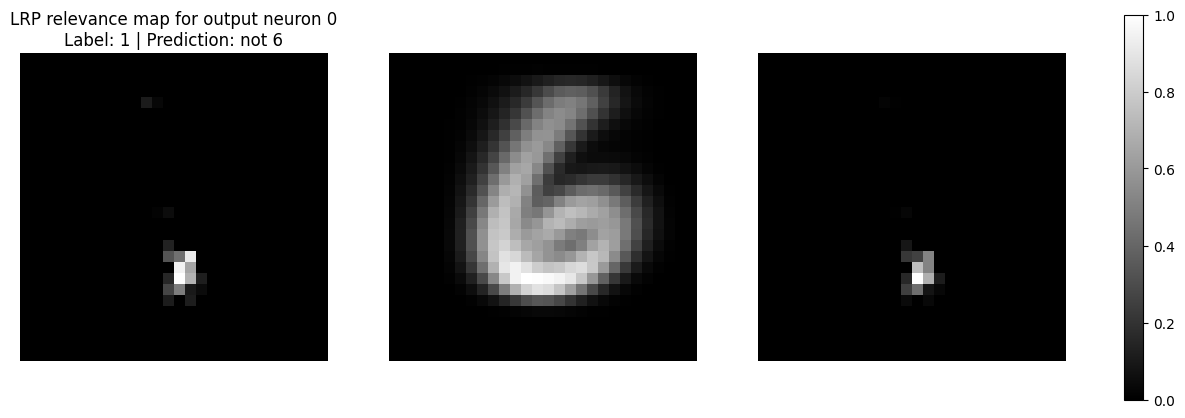

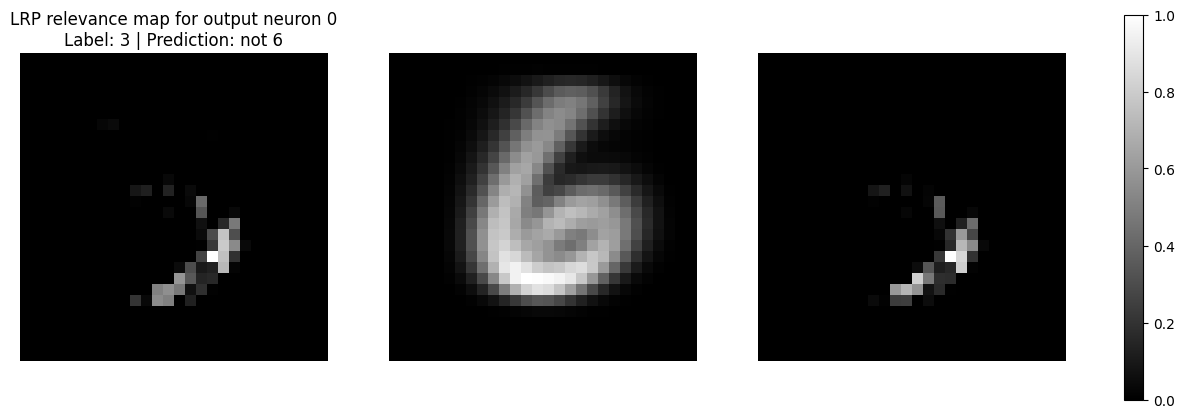

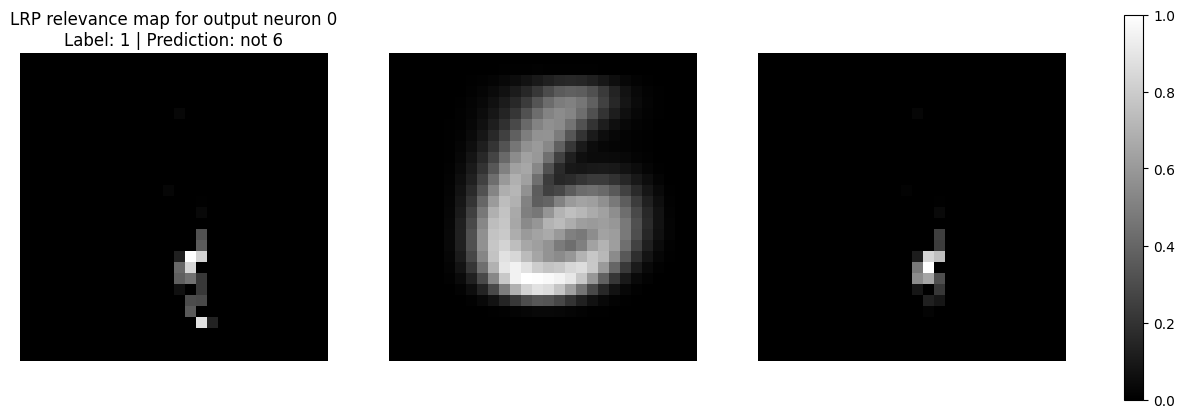

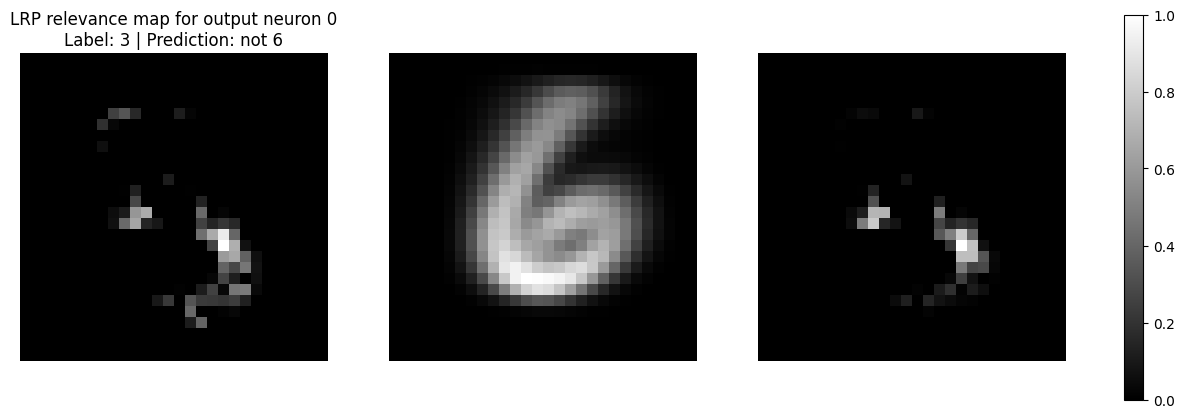

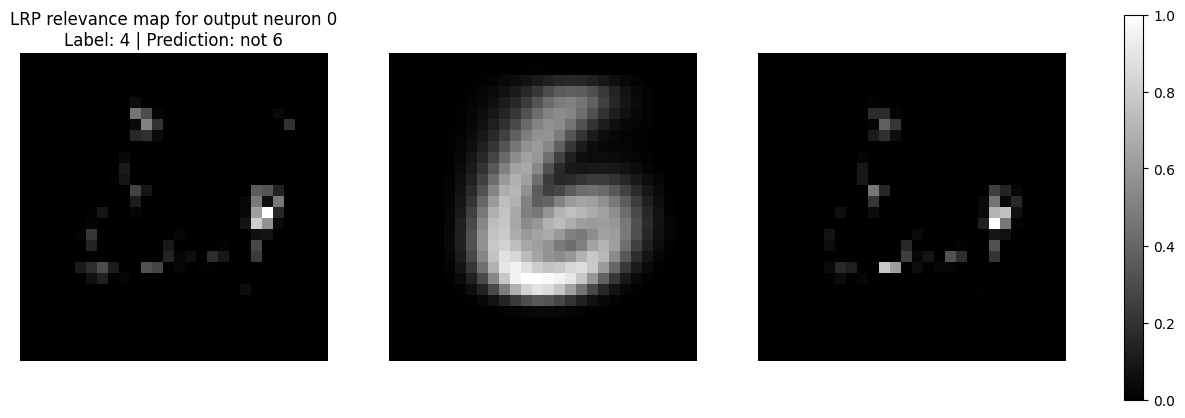

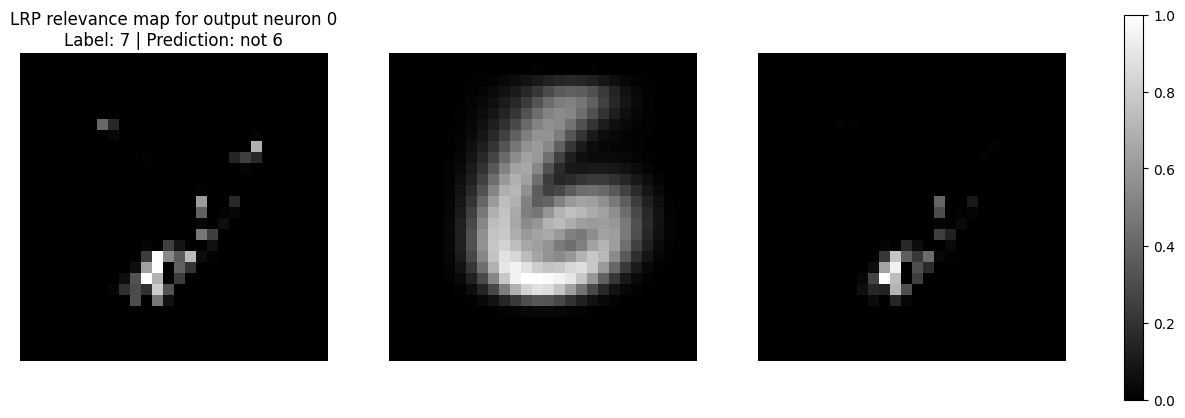

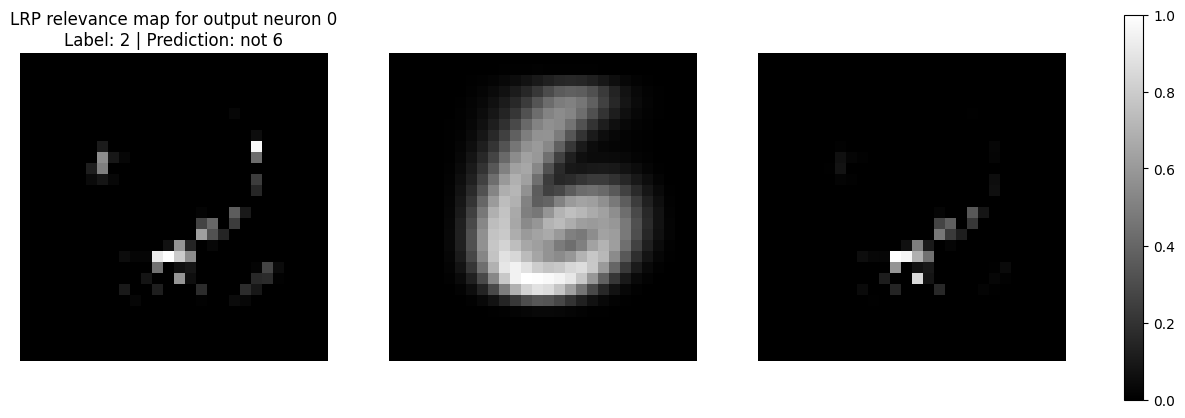

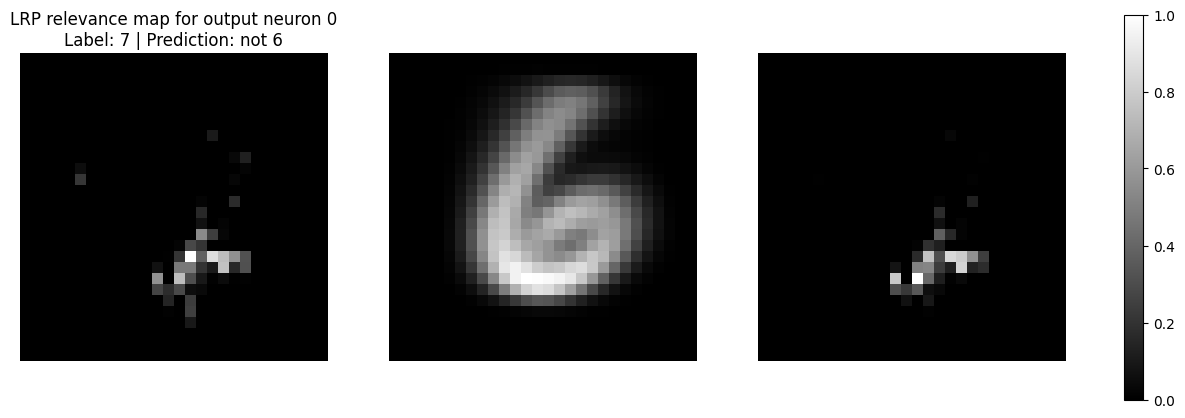

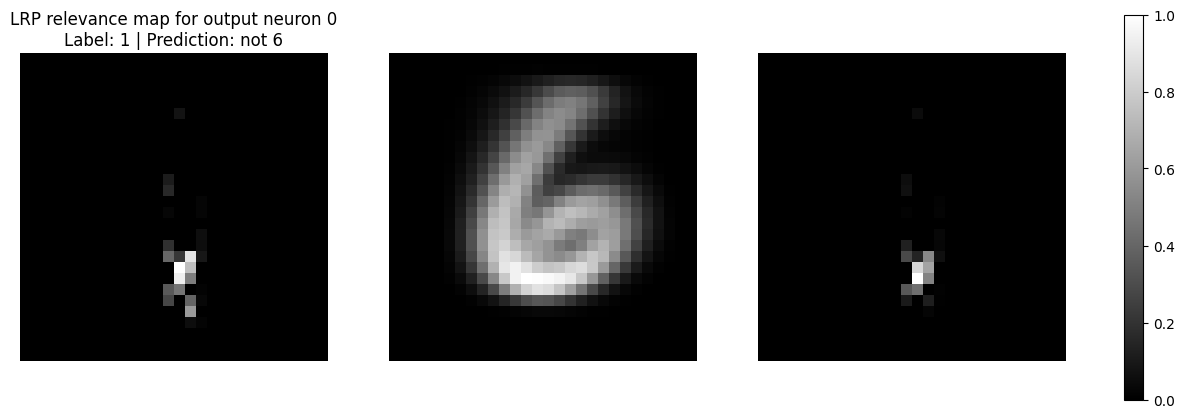

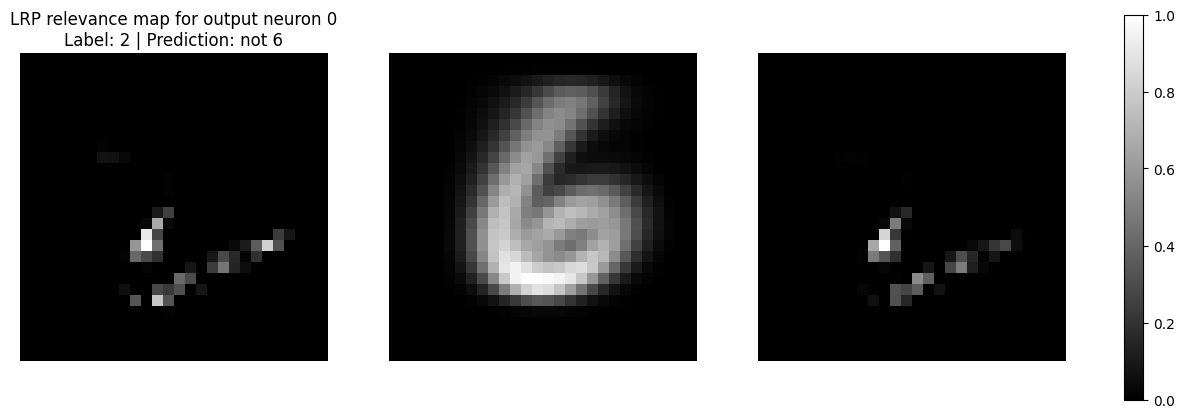

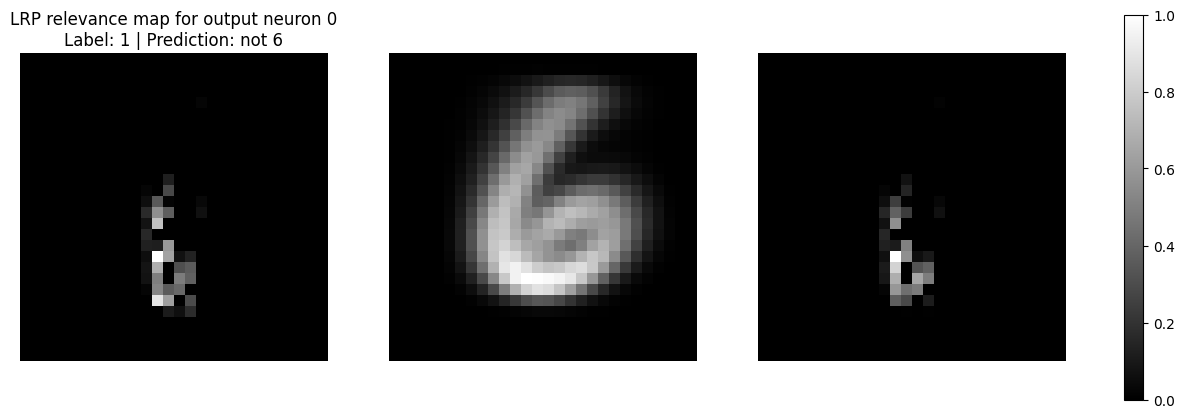

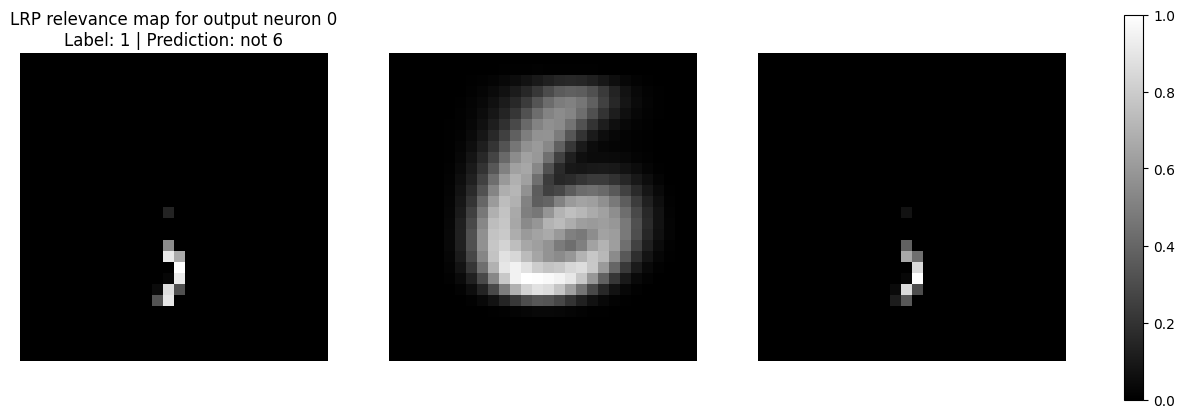

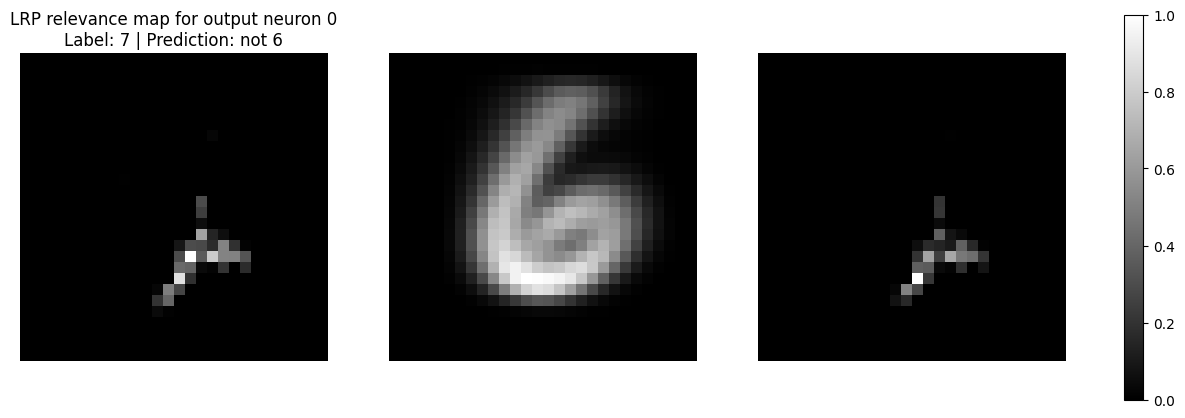

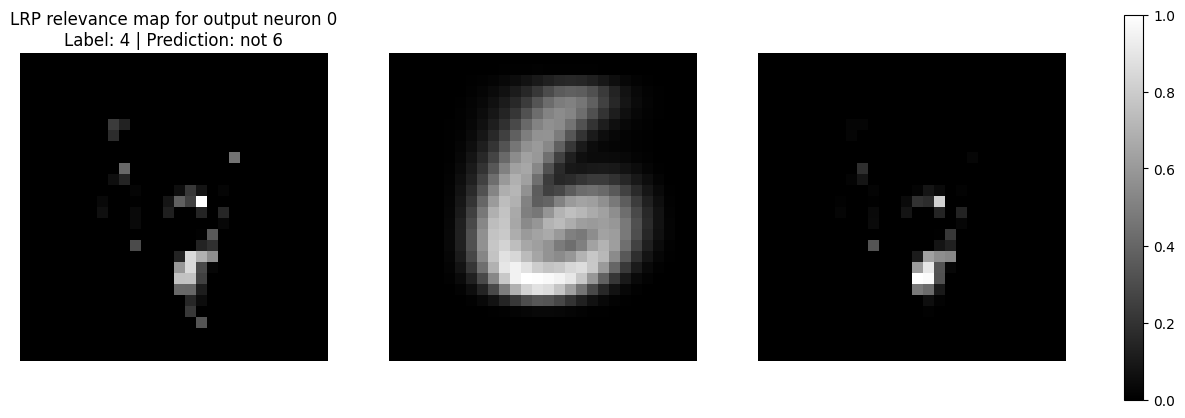

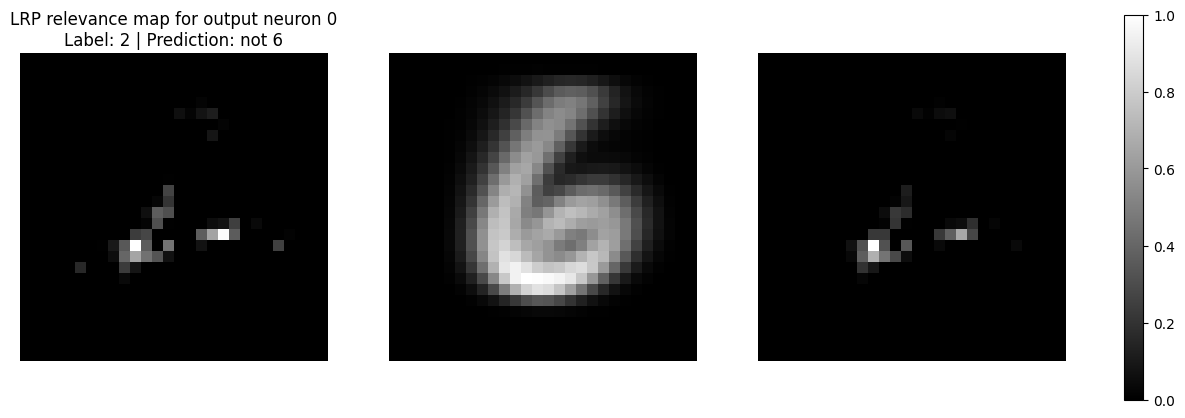

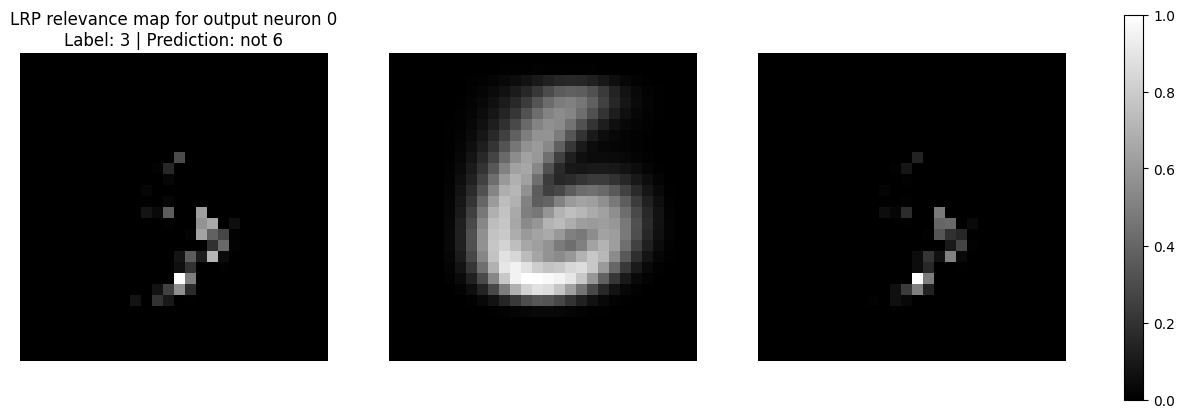

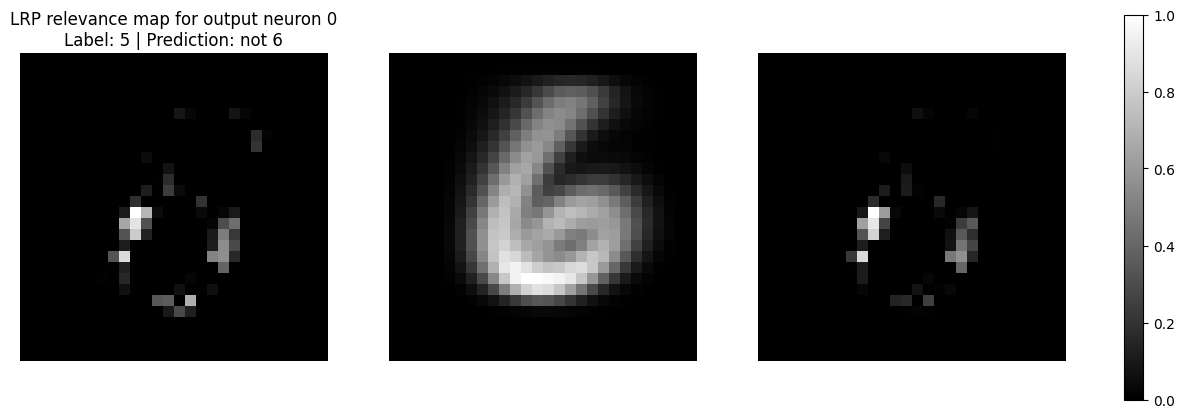

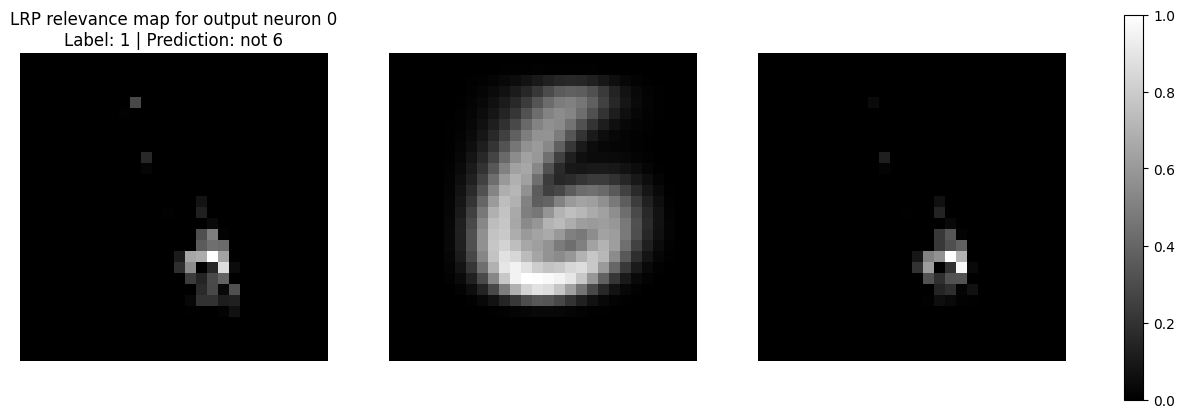

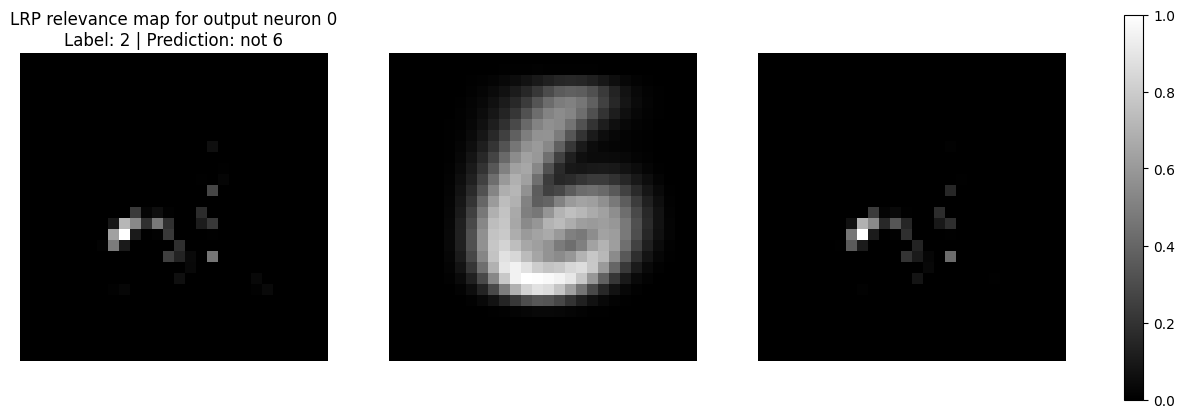

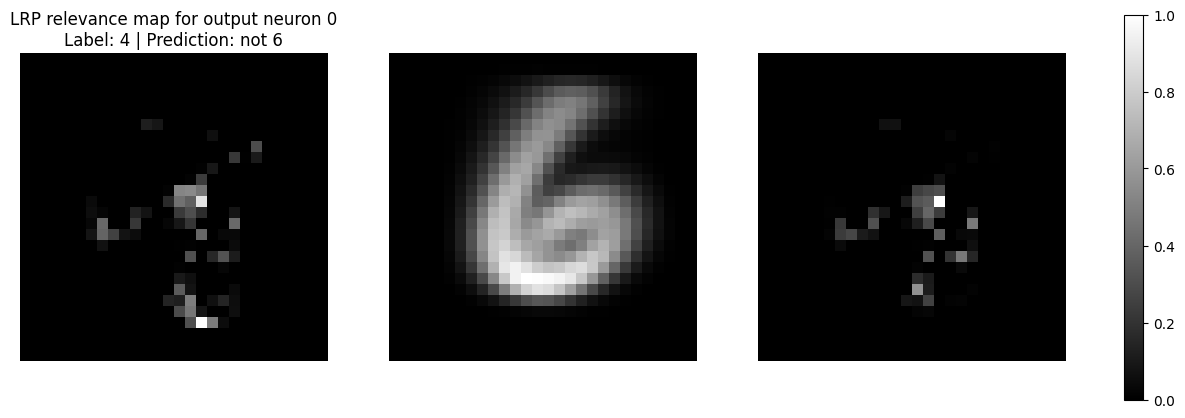

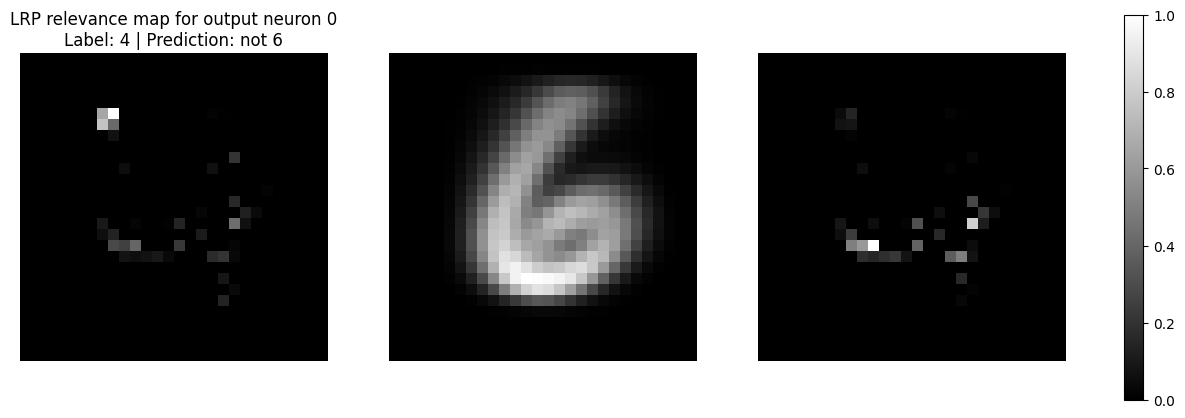

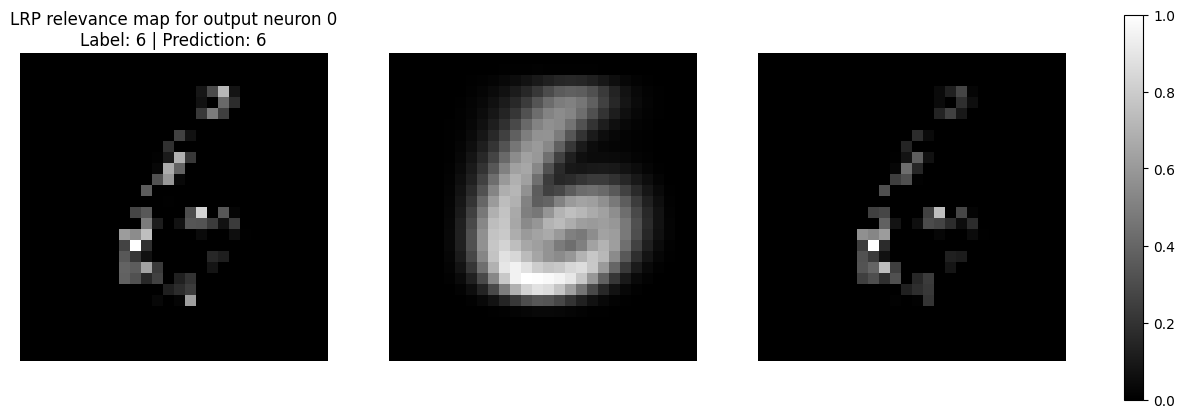

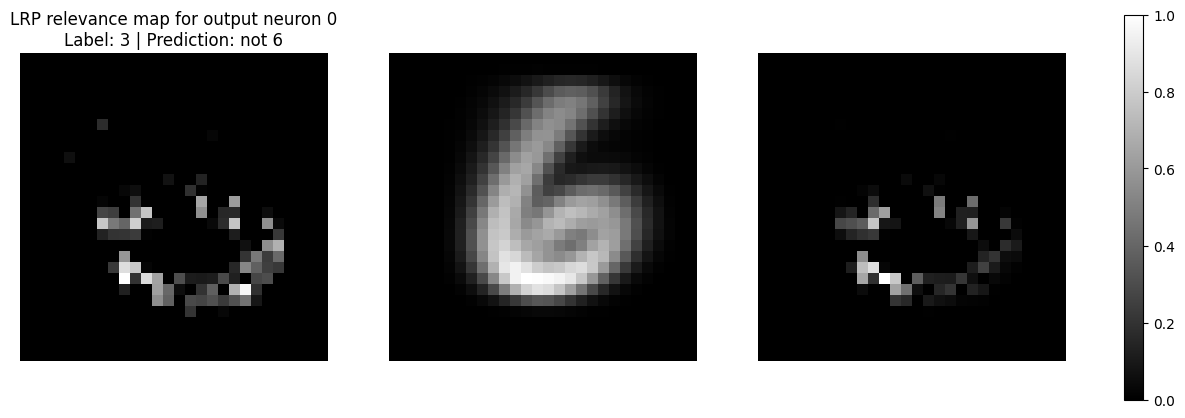

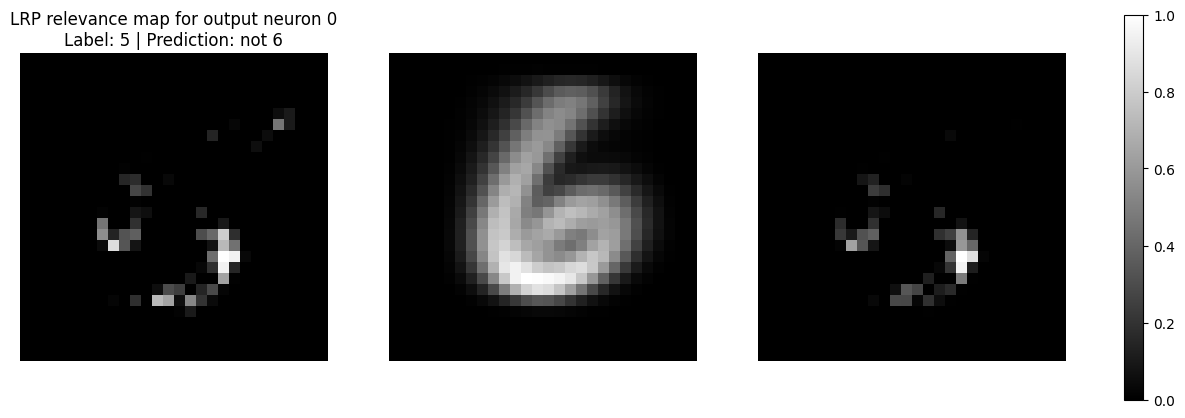

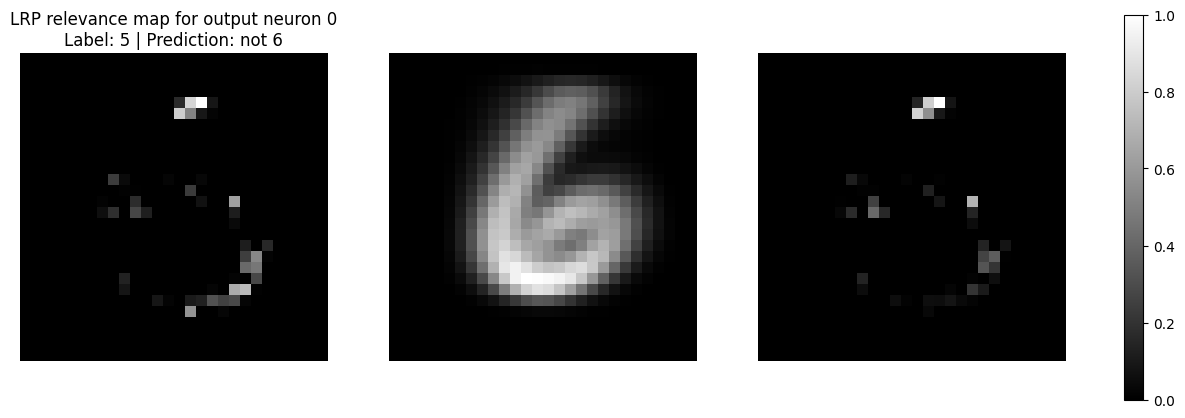

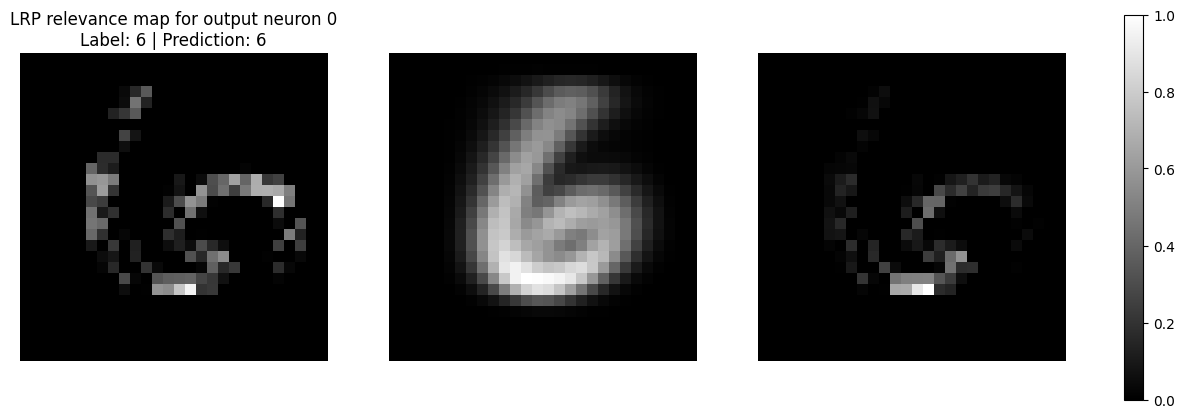

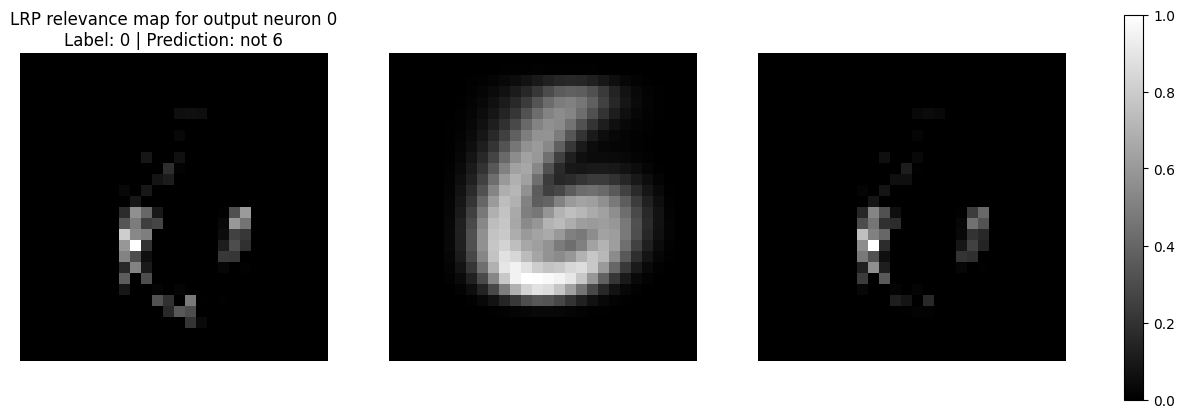

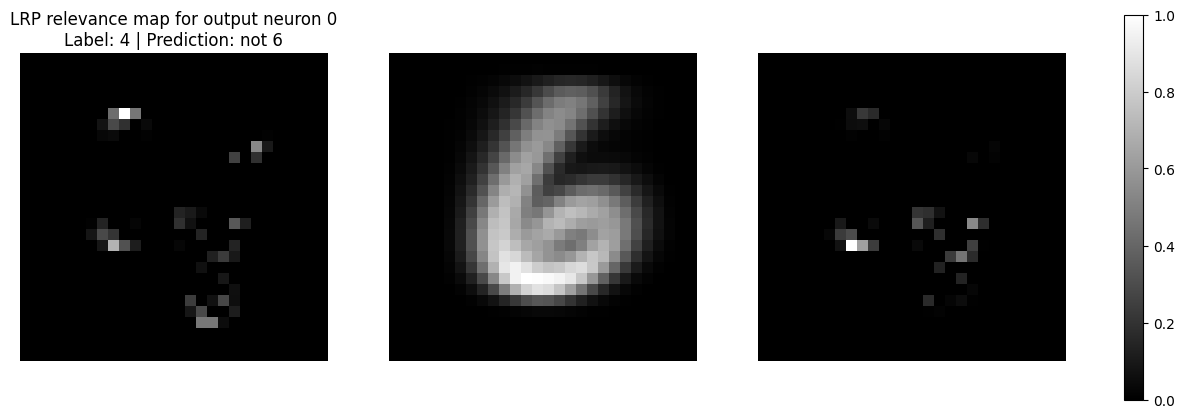

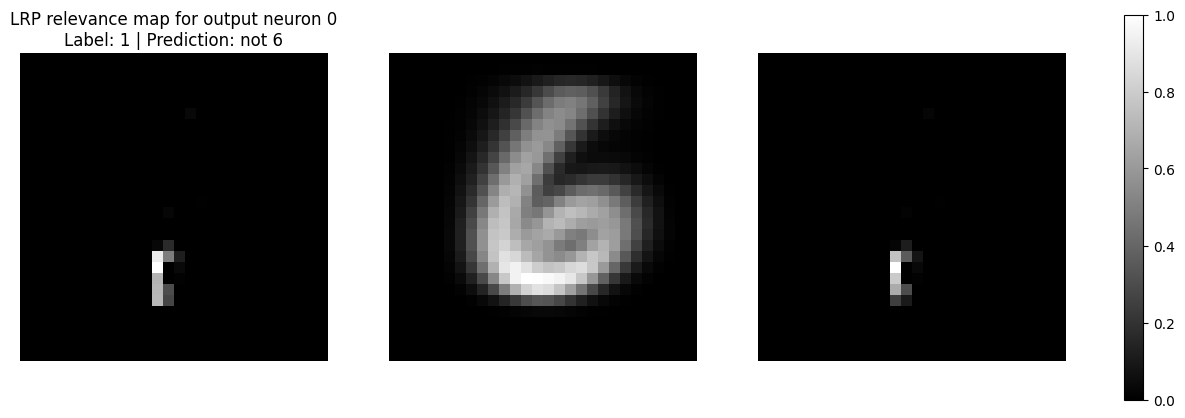

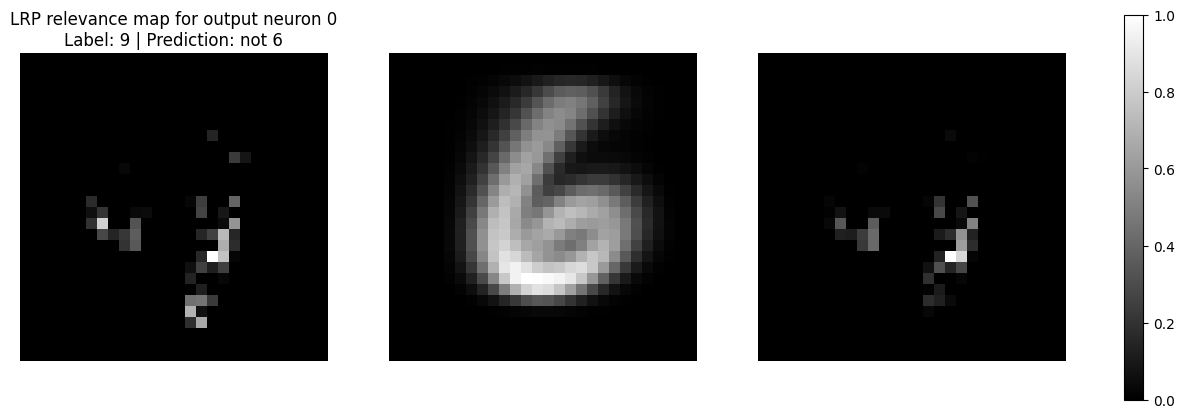

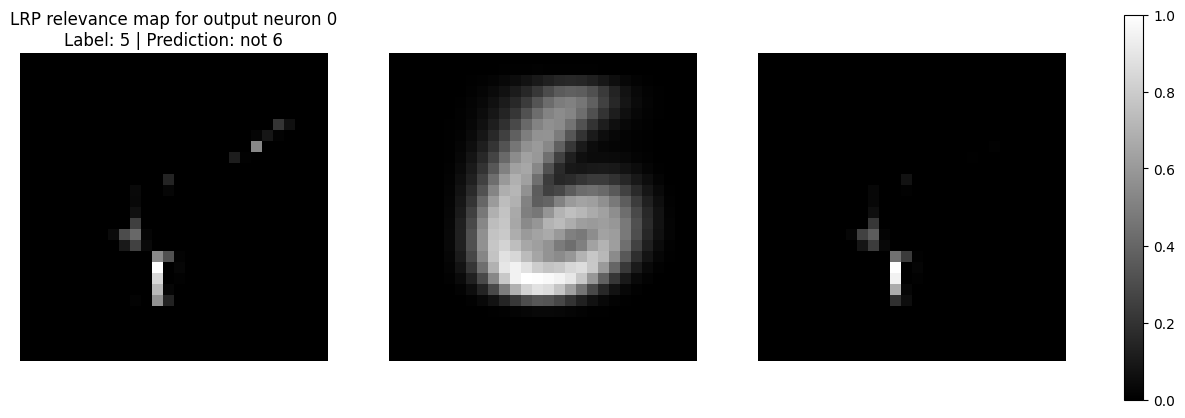

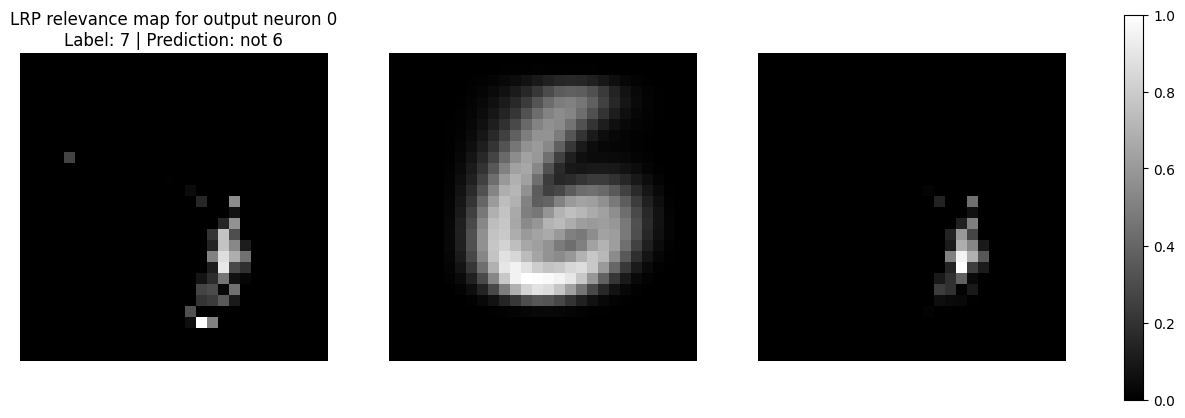

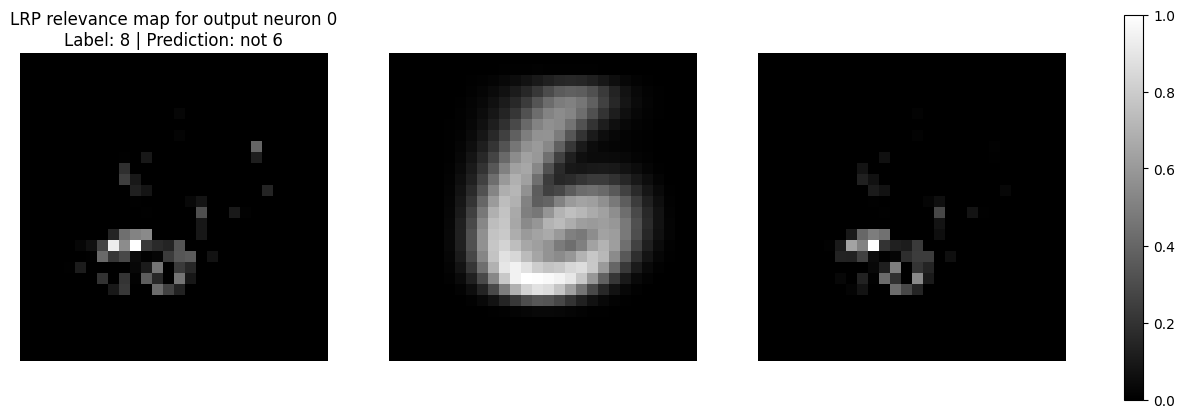

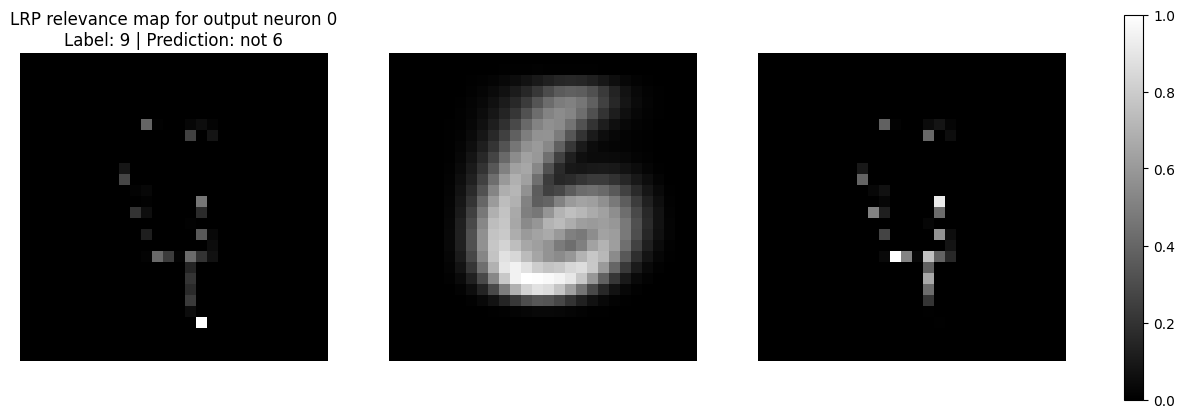

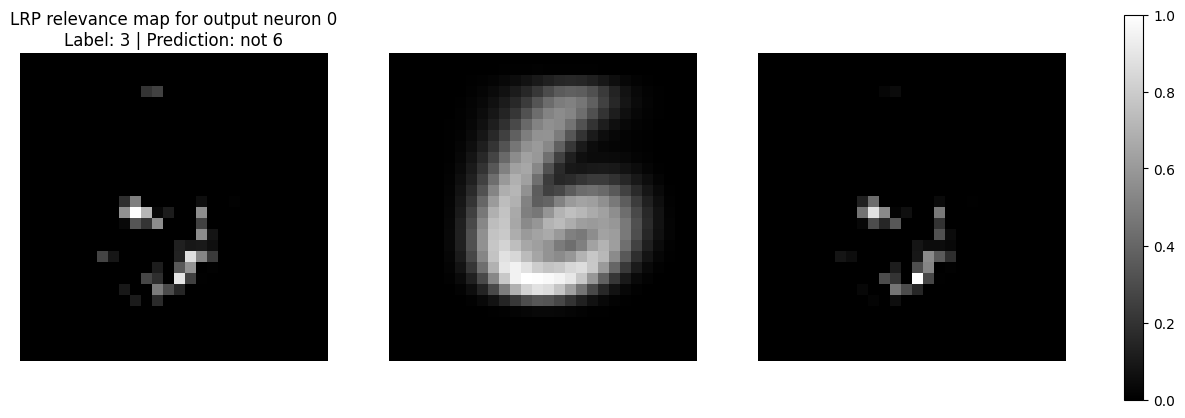

In [15]:
inputs, labels = next(iter(test_loader))
ind = ra.randrange(0, len(inputs))

for ind in range(len(inputs)):
    input = inputs[ind].unsqueeze(0).cuda()
    input.requires_grad_()

    label = labels[ind].item()

    net.eval()
    with torch.no_grad():
        output = net(input)
        prob = torch.sigmoid(output)
        prediction = (prob >= 0.5).int().item()



    lrp = LRP(net)
    target = torch.tensor(0).cuda() #which neuron, there is only one

    attributions = lrp.attribute(input, target=target)

    rel_map = attributions[0].cpu().detach().numpy().reshape(28, 28)

    with torch.no_grad():
        input_np = input[0].cpu().numpy().reshape(28, 28)  #input image

    background_mask = (input_np == 0)

    min_val = rel_map.min()

    rel_map[background_mask] = min_val

    rel_map = np.maximum(rel_map, 0)

    #normalise:
    rel_max = rel_map.max()
    rel_map /= rel_max

    average_max = average_img.max()
    average_img / average_max

    #get overlaps with average bin_digit:
    #mat_diff = 1 - (rel_map-average_img)
    #mat_avg = (abs(rel_map) + abs(average_img)) / 2
    #mat_diff *= -(mat_avg)

    mat_overlap = rel_map * average_img

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(rel_map, cmap='gray', interpolation='nearest')
    prediction = 1 - prediction
    ax1.set_title(f"LRP relevance map for output neuron {target.item()}\nLabel: {label} | Prediction:{' not'*prediction} {bin_digit}")
    ax1.axis('off')

    ax2.imshow(average_img, cmap="gray")
    ax2.axis('off')

    ax3.imshow(mat_overlap, cmap='gray', interpolation='nearest')
    ax3.axis('off')

    fig.colorbar(ax1.images[0], ax=[ax1, ax2, ax3], orientation='vertical', fraction=0.05)

    #plt.tight_layout()
    plt.show()




In [16]:
#activation maximisation:

In [17]:
import torch.nn.functional as F
import math

In [18]:
def maximize_neuron(model, layer: str, neuron_idx: int, steps=200, lr=0.1, l2_decay=1e-4):
    model.eval()
    img = torch.randn(1, 1, 28, 28, requires_grad=True, device=next(model.parameters()).device)
    optimizer = torch.optim.Adam([img], lr=lr)

    for _ in range(steps):
        optimizer.zero_grad()

        x = img.view(1, -1)
        x0 = model.relu(model.fc0(x))
        x1 = model.relu(model.fc1(x0))
        x2 = model.fc2(x1)             #logit out

        if layer == 'fc0':
            activation = x0[0, neuron_idx]
        elif layer == 'fc1':
            activation = x1[0, neuron_idx]
        elif layer == 'fc2':
            activation = x2[0, neuron_idx]
        else:
            raise ValueError("Invalid layer name")

        loss = -activation + l2_decay * (img ** 2).mean()
        loss.backward()
        optimizer.step()

    return img.detach().squeeze().cpu().clamp(0, 1)


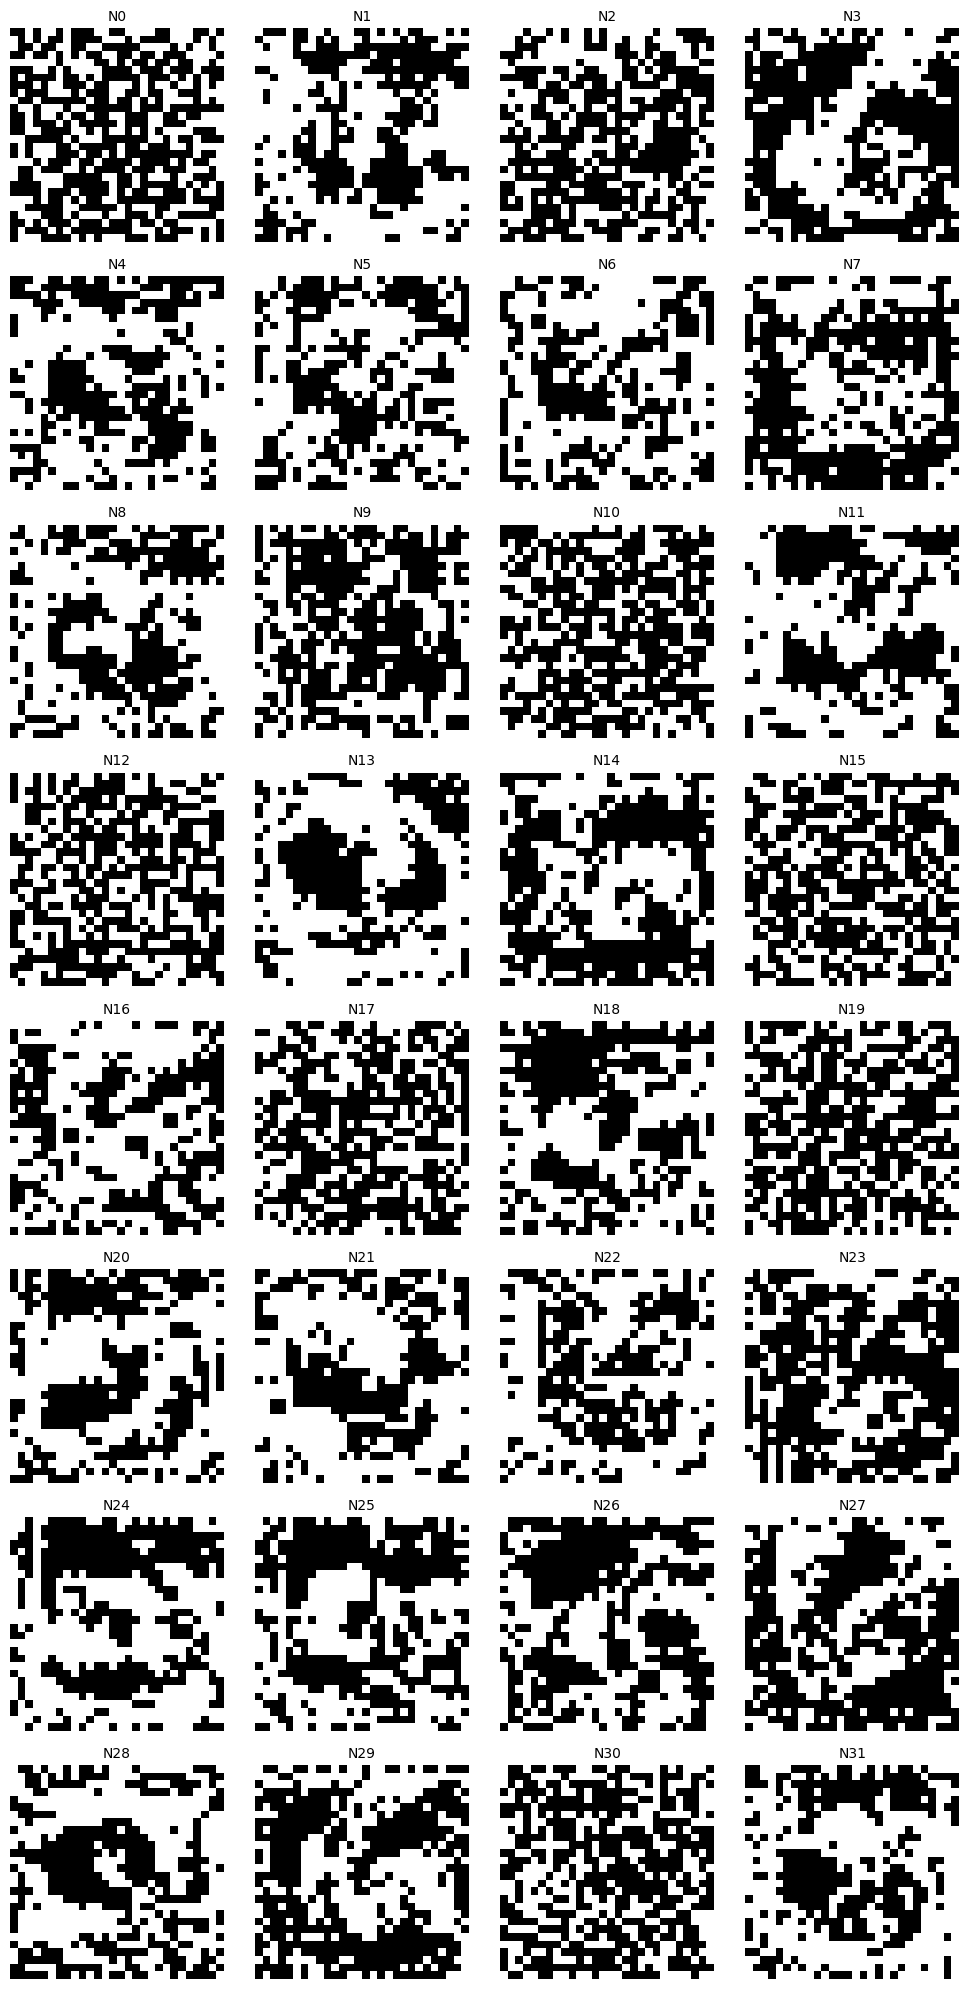

In [19]:
def plot_maximized_neurons(model, layer: str, num_neurons: int, cols: int = 4, img_size: float = 2.5):
    rows = math.ceil(num_neurons / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * img_size, rows * img_size))

    for i in range(rows * cols):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i]
        if i < num_neurons:
            img = maximize_neuron(model, layer, i)
            ax.imshow(img.numpy(), cmap='gray')
            ax.set_title(f'N{i}', fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_maximized_neurons(net, layer='fc0', num_neurons=32)


In [50]:
inputs, labels = next(iter(test_loader))
ind = ra.randrange(0, len(inputs))

for ind in range(len(inputs)):
    input = inputs[ind].unsqueeze(0).cuda()
    input.requires_grad_()

    label = labels[ind].item()

    net.eval()
    with torch.no_grad():
        output = net(input)
        prob = torch.sigmoid(output)
        prediction = (prob >= 0.5).int().item()
        print(f"{output.item()} | {prob.item()}")

-32.81432342529297 | 5.609451976269081e-15
-20.56159210205078 | 1.175476604942105e-09
-11.08880615234375 | 1.5282204913091846e-05
-13.720132827758789 | 1.1000730637533707e-06
-14.755746841430664 | 3.905353764821484e-07
-18.787443161010742 | 6.929742557559848e-09
-16.118906021118164 | 9.991898508587838e-08
-26.454225540161133 | 3.2439621735352864e-12
-5.251126289367676 | 0.00521428044885397
-36.560813903808594 | 1.3238546600900417e-16
-15.731658935546875 | 1.4717269891662e-07
12.827425003051758 | 0.9999972581863403
-29.319196701049805 | 1.848564704087785e-13
-12.985118865966797 | 2.294211981279659e-06
-20.160247802734375 | 1.7559640408393307e-09
-12.540054321289062 | 3.580321390472818e-06
-23.37851905822754 | 7.028103793382812e-11
-33.33523941040039 | 3.3318809662647537e-15
-16.658227920532227 | 5.8267112024168455e-08
-14.782742500305176 | 3.80133656108228e-07
-38.09018325805664 | 2.86842579067871e-17
5.185401439666748 | 0.9944334626197815
13.359947204589844 | 0.9999984502792358
-15.727

In [21]:
#output above shows that model is very confident, important to note. Value are either close to 0 or 1, sigmoid range from 0 to 1!

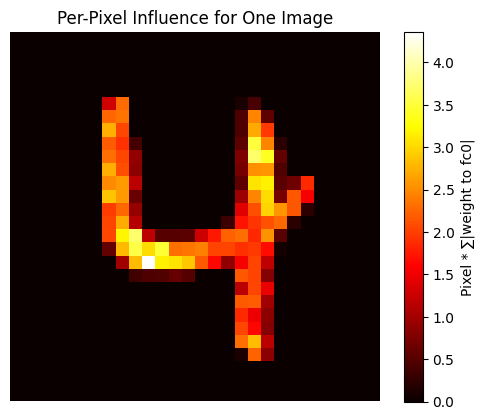

In [114]:
import matplotlib.pyplot as plt
import random as ra

inputs, labels = next(iter(test_loader))
ind = ra.randrange(0, len(inputs))
img = inputs[ind].squeeze() #[28, 28]

weights = net.fc0.weight.detach().cpu() #[32, 784]
importance = weights.abs().sum(dim=0).view(28, 28) #[28, 28]

influence = img * importance #[28, 28] 

plt.imshow(influence, cmap='hot', vmin=0, vmax=influence.max())
plt.colorbar(label='Pixel * ∑|weight to fc0|')
plt.title('Per-Pixel Influence for One Image')
plt.axis('off')
plt.show()